# records

In [1]:
import vectorbt as vbt

In [2]:
import numpy as np
import pandas as pd
from numba import njit
from collections import namedtuple
from datetime import datetime

In [3]:
# Disable caching for performance testing
# NOTE: Expect waterfall of executions, since some attributes depend on other attributes 
# that have to be calculated again and again
vbt.defaults.caching['properties'] = False
vbt.defaults.caching['methods'] = False

In [4]:
example_dt = np.dtype([
    ('col', np.int64),
    ('idx', np.int64),
    ('some_field1', np.float64),
    ('some_field2', np.float64)
], align=True)

In [5]:
records_arr = np.asarray([
    (0, 0, 10, 21),
    (0, 1, 11, 20),
    (0, 2, 12, 19),
    (1, 0, 13, 18),
    (1, 1, 14, 17),
    (1, 2, 13, 18),
    (2, 0, 12, 19),
    (2, 1, 11, 20),
    (2, 2, 10, 21)
], dtype=example_dt)
print(records_arr)
print(records_arr.shape)

columns = pd.MultiIndex.from_arrays([[0, 1, 1, 1], ['a', 'b', 'c', 'd']], names=['lvl1', 'lvl2'])
wrapper = vbt.ArrayWrapper(index=['x', 'y', 'z'], columns=columns, ndim=2, freq='1 days')
records = vbt.Records(wrapper, records_arr)

records_grouped = vbt.Records(wrapper.copy(group_by=0), records_arr)

[(0, 0, 10., 21.) (0, 1, 11., 20.) (0, 2, 12., 19.) (1, 0, 13., 18.)
 (1, 1, 14., 17.) (1, 2, 13., 18.) (2, 0, 12., 19.) (2, 1, 11., 20.)
 (2, 2, 10., 21.)]
(9,)


In [6]:
big_records_arr = np.asarray(list(zip(*(
    np.repeat(np.arange(1000), 1000),
    np.tile(np.arange(1000), 1000),
    np.random.randint(0, 100, size=1000000),
    np.random.randint(0, 100, size=1000000)))), dtype=example_dt)
print(big_records_arr.shape)

big_columns = pd.MultiIndex.from_arrays([np.repeat(np.array([0, 1]), 500), np.arange(1000)], names=['lvl1', 'lvl2'])
big_wrapper = vbt.ArrayWrapper(index=np.arange(1000), columns=big_columns, ndim=2, freq='1 days')
big_records = vbt.Records(big_wrapper, big_records_arr)

big_records_grouped = vbt.Records(big_wrapper.copy(group_by=0), big_records_arr)

(1000000,)


In [7]:
records_nosort = records.copy(records_arr=records.records_arr[::-1])
print(records_nosort.records_arr)

big_records_nosort = big_records.copy(records_arr=big_records.records_arr[::-1])

[(2, 2, 10., 21.) (2, 1, 11., 20.) (2, 0, 12., 19.) (1, 2, 13., 18.)
 (1, 1, 14., 17.) (1, 0, 13., 18.) (0, 2, 12., 19.) (0, 1, 11., 20.)
 (0, 0, 10., 21.)]


In [8]:
group_by = pd.Series(['first', 'first', 'second', 'second'], name='group')
big_group_by = pd.Series(np.repeat(np.array([0, 1]), 500))

## ColumnMapper

In [9]:
print(records.col_mapper.col_arr)

[0 0 0 1 1 1 2 2 2]


In [10]:
print(records.col_mapper.get_col_arr())
print(records_grouped.col_mapper.get_col_arr())

%timeit big_records_grouped.col_mapper.get_col_arr()

[0 0 0 1 1 1 2 2 2]
[0 0 0 1 1 1 1 1 1]
4.34 ms ± 30.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
print(records.col_mapper.col_range)

%timeit big_records.col_mapper.col_range

[[ 0  3]
 [ 3  6]
 [ 6  9]
 [-1 -1]]
2.63 ms ± 451 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
print(records.col_mapper.get_col_range())
print(records_grouped.col_mapper.get_col_range())

%timeit big_records_grouped.col_mapper.get_col_range()

[[ 0  3]
 [ 3  6]
 [ 6  9]
 [-1 -1]]
[[0 3]
 [3 9]]
4.91 ms ± 109 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
print(records.col_mapper.col_map)

%timeit big_records.col_mapper.col_map

(array([[                   0,                    1,                    2],
       [                   3,                    4,                    5],
       [                   6,                    7,                    8],
       [-3761688987579986997, -3761688987579986997, -3761688987579986997]]), array([3, 3, 3, 0]))
13 ms ± 252 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
print(records.col_mapper.get_col_map())
print(records_grouped.col_mapper.get_col_map())

%timeit big_records_grouped.col_mapper.get_col_map()

(array([[                   0,                    1,                    2],
       [                   3,                    4,                    5],
       [                   6,                    7,                    8],
       [-3761688987579986997, -3761688987579986997, -3761688987579986997]]), array([3, 3, 3, 0]))
(array([[                   0,                    1,                    2,
        -3761688987579986997, -3761688987579986997, -3761688987579986997],
       [                   3,                    4,                    5,
                           6,                    7,                    8]]), array([3, 6]))
9.01 ms ± 944 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
print(records.col_mapper.is_sorted())
%timeit big_records.col_mapper.is_sorted()

print(records_nosort.col_mapper.is_sorted())
%timeit big_records_nosort.col_mapper.is_sorted()

True
4.03 ms ± 64.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
False
3.74 ms ± 290 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## MappedArray

In [16]:
mapped_array = records.map_field('some_field1')
big_mapped_array = big_records.map_field('some_field1')

mapped_array_nosort = records_nosort.map_field('some_field1')
big_mapped_array_nosort = big_records_nosort.map_field('some_field1')

mapped_array_grouped = records_grouped.map_field('some_field1')
big_mapped_array_grouped = big_records_grouped.map_field('some_field1')

In [17]:
print(mapped_array[(0, 'a')].values)
print(mapped_array[(0, 'a')].col_arr)
print(mapped_array[(0, 'a')].wrapper.columns)

print(mapped_array[(1, 'b')].values)
print(mapped_array[(1, 'b')].col_arr)
print(mapped_array[(1, 'b')].wrapper.columns)

print(mapped_array[[(0, 'a'), (0, 'a')]].values)
print(mapped_array[[(0, 'a'), (0, 'a')]].col_arr)
print(mapped_array[[(0, 'a'), (0, 'a')]].wrapper.columns)

print(mapped_array[[(0, 'a'), (1, 'b')]].values)
print(mapped_array[[(0, 'a'), (1, 'b')]].col_arr)
print(mapped_array[[(0, 'a'), (1, 'b')]].wrapper.columns)

%timeit big_mapped_array.iloc[0]
%timeit big_mapped_array.iloc[:]

[10. 11. 12.]
[0 0 0]
MultiIndex([(0, 'a')],
           names=['lvl1', 'lvl2'])
[13. 14. 13.]
[0 0 0]
MultiIndex([(1, 'b')],
           names=['lvl1', 'lvl2'])
[10. 11. 12. 10. 11. 12.]
[0 0 0 1 1 1]
MultiIndex([(0, 'a'),
            (0, 'a')],
           names=['lvl1', 'lvl2'])
[10. 11. 12. 13. 14. 13.]
[0 0 0 1 1 1]
MultiIndex([(0, 'a'),
            (1, 'b')],
           names=['lvl1', 'lvl2'])
6.82 ms ± 81 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
24.8 ms ± 4.94 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
print(mapped_array_nosort[(0, 'a')].values)
print(mapped_array_nosort[(0, 'a')].col_arr)
print(mapped_array_nosort[(0, 'a')].wrapper.columns)

print(mapped_array_nosort[(1, 'b')].values)
print(mapped_array_nosort[(1, 'b')].col_arr)
print(mapped_array_nosort[(1, 'b')].wrapper.columns)

print(mapped_array_nosort[[(0, 'a'), (0, 'a')]].values)
print(mapped_array_nosort[[(0, 'a'), (0, 'a')]].col_arr)
print(mapped_array_nosort[[(0, 'a'), (0, 'a')]].wrapper.columns)

print(mapped_array_nosort[[(0, 'a'), (1, 'b')]].values)
print(mapped_array_nosort[[(0, 'a'), (1, 'b')]].col_arr)
print(mapped_array_nosort[[(0, 'a'), (1, 'b')]].wrapper.columns)

%timeit big_mapped_array_nosort.iloc[0]
%timeit big_mapped_array_nosort.iloc[:]

[12. 11. 10.]
[0 0 0]
MultiIndex([(0, 'a')],
           names=['lvl1', 'lvl2'])
[13. 14. 13.]
[0 0 0]
MultiIndex([(1, 'b')],
           names=['lvl1', 'lvl2'])
[12. 11. 10. 12. 11. 10.]
[0 0 0 1 1 1]
MultiIndex([(0, 'a'),
            (0, 'a')],
           names=['lvl1', 'lvl2'])
[12. 11. 10. 13. 14. 13.]
[0 0 0 1 1 1]
MultiIndex([(0, 'a'),
            (1, 'b')],
           names=['lvl1', 'lvl2'])
19.3 ms ± 178 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
36.8 ms ± 3.34 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
print(mapped_array_grouped[0].wrapper.columns)  # indexing on groups, not columns!
print(mapped_array_grouped[0].wrapper.ndim)
print(mapped_array_grouped[0].wrapper.grouped_ndim)
print(mapped_array_grouped[0].wrapper.grouper.group_by)

print(mapped_array_grouped[1].wrapper.columns)
print(mapped_array_grouped[1].wrapper.ndim)
print(mapped_array_grouped[1].wrapper.grouped_ndim)
print(mapped_array_grouped[1].wrapper.grouper.group_by)

print(mapped_array_grouped[[0]].wrapper.columns)
print(mapped_array_grouped[[0]].wrapper.ndim)
print(mapped_array_grouped[[0]].wrapper.grouped_ndim)
print(mapped_array_grouped[[0]].wrapper.grouper.group_by)

print(mapped_array_grouped[[0, 1]].wrapper.columns)
print(mapped_array_grouped[[0, 1]].wrapper.ndim)
print(mapped_array_grouped[[0, 1]].wrapper.grouped_ndim)
print(mapped_array_grouped[[0, 1]].wrapper.grouper.group_by)

%timeit big_mapped_array_grouped.iloc[0]
%timeit big_mapped_array_grouped.iloc[:]

MultiIndex([(0, 'a')],
           names=['lvl1', 'lvl2'])
1
1
Int64Index([0], dtype='int64', name='lvl1')
MultiIndex([(1, 'b'),
            (1, 'c'),
            (1, 'd')],
           names=['lvl1', 'lvl2'])
2
1
Int64Index([1, 1, 1], dtype='int64', name='lvl1')
MultiIndex([(0, 'a')],
           names=['lvl1', 'lvl2'])
2
2
Int64Index([0], dtype='int64', name='lvl1')
MultiIndex([(0, 'a'),
            (1, 'b'),
            (1, 'c'),
            (1, 'd')],
           names=['lvl1', 'lvl2'])
2
2
Int64Index([0, 1, 1, 1], dtype='int64', name='lvl1')
16.8 ms ± 206 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
23 ms ± 190 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
print(mapped_array.wrapper.index)
print(mapped_array.wrapper.columns)
print(mapped_array.wrapper.ndim)
print(mapped_array.wrapper.grouper.group_by)

print(mapped_array_grouped.wrapper.index)
print(mapped_array_grouped.wrapper.columns)
print(mapped_array_grouped.wrapper.ndim)
print(mapped_array_grouped.wrapper.grouper.group_by)

Index(['x', 'y', 'z'], dtype='object')
MultiIndex([(0, 'a'),
            (1, 'b'),
            (1, 'c'),
            (1, 'd')],
           names=['lvl1', 'lvl2'])
2
None
Index(['x', 'y', 'z'], dtype='object')
MultiIndex([(0, 'a'),
            (1, 'b'),
            (1, 'c'),
            (1, 'd')],
           names=['lvl1', 'lvl2'])
2
Int64Index([0, 1, 1, 1], dtype='int64', name='lvl1')


In [21]:
print(mapped_array.values)

[10. 11. 12. 13. 14. 13. 12. 11. 10.]


In [22]:
print(mapped_array.idx_arr)

[0 1 2 0 1 2 0 1 2]


In [23]:
print(mapped_array.col_arr)

[0 0 0 1 1 1 2 2 2]


In [24]:
print(mapped_array.is_sorted())
%timeit big_mapped_array.is_sorted()

print(mapped_array_nosort.is_sorted())
%timeit big_mapped_array_nosort.is_sorted()

print(mapped_array.is_sorted(incl_idx=True))
%timeit big_mapped_array.is_sorted(incl_idx=True)

print(mapped_array_nosort.is_sorted(incl_idx=True))
%timeit big_mapped_array_nosort.is_sorted(incl_idx=True)

True
2.14 ms ± 88.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
False
3.21 µs ± 65.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
True
2.41 ms ± 73.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
False
2.79 µs ± 347 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [25]:
print(mapped_array.sort().col_arr)
print(mapped_array.sort().idx_arr)
%timeit big_mapped_array.sort()

print(mapped_array_nosort.sort().col_arr)
print(mapped_array_nosort.sort().idx_arr)
%timeit big_mapped_array_nosort.sort()

print(mapped_array.sort(incl_idx=True).col_arr)
print(mapped_array.sort(incl_idx=True).idx_arr)
%timeit big_mapped_array.sort(incl_idx=True)

print(mapped_array_nosort.sort(incl_idx=True).col_arr)
print(mapped_array_nosort.sort(incl_idx=True).idx_arr)
%timeit big_mapped_array_nosort.sort(incl_idx=True)

[0 0 0 1 1 1 2 2 2]
[0 1 2 0 1 2 0 1 2]
2.19 ms ± 33.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
[0 0 0 1 1 1 2 2 2]
[2 1 0 2 1 0 2 1 0]
51.5 ms ± 9.83 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
[0 0 0 1 1 1 2 2 2]
[0 1 2 0 1 2 0 1 2]
2.49 ms ± 93.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
[0 0 0 1 1 1 2 2 2]
[0 1 2 0 1 2 0 1 2]
119 ms ± 25.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [35]:
mask = mapped_array.values >= mapped_array.values.mean()
print(mapped_array.filter_by_mask(mask).values)

big_mask = big_mapped_array.values >= big_mapped_array.values.mean()
%timeit big_mapped_array.filter_by_mask(big_mask)
%timeit big_mapped_array_nosort.filter_by_mask(big_mask)

[12. 13. 14. 13. 12.]
27.4 ms ± 2.94 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
30.7 ms ± 5.11 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [36]:
@njit
def every_2_nb(inout, idxs, col, mapped_arr):
    inout[idxs[::2]] = True

print(mapped_array.map_to_mask(every_2_nb))
%timeit big_mapped_array.map_to_mask(every_2_nb)
%timeit big_mapped_array_nosort.map_to_mask(every_2_nb)

[ True False  True  True False  True  True False  True]
19 ms ± 397 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
19.9 ms ± 176 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [29]:
print(mapped_array.values)

print(mapped_array.top_n_mask(1))
%timeit big_mapped_array.top_n_mask(100)

print(mapped_array.bottom_n_mask(1))
%timeit big_mapped_array.bottom_n_mask(100)

[10. 11. 12. 13. 14. 13. 12. 11. 10.]
[False False  True False  True False  True False False]
82.3 ms ± 4.43 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
[ True False False  True False False False False  True]
78.2 ms ± 669 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [30]:
print(mapped_array.top_n(1).values)
%timeit big_mapped_array.top_n(100)

print(mapped_array.bottom_n(1).values)
%timeit big_mapped_array.bottom_n(100)

[12. 14. 12.]
99.8 ms ± 11.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
[10. 13. 10.]
90.6 ms ± 552 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [31]:
print(mapped_array.is_matrix_compatible())

%timeit big_mapped_array.is_matrix_compatible()

True
11.7 ms ± 157 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [32]:
print(mapped_array.to_matrix())
print(mapped_array.to_matrix(default_val=0.))

%timeit big_mapped_array.to_matrix()

lvl1     0     1          
lvl2     a     b     c   d
x     10.0  13.0  12.0 NaN
y     11.0  14.0  11.0 NaN
z     12.0  13.0  10.0 NaN
lvl1     0     1           
lvl2     a     b     c    d
x     10.0  13.0  12.0  0.0
y     11.0  14.0  11.0  0.0
z     12.0  13.0  10.0  0.0
24.9 ms ± 1.67 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [34]:
@njit
def mean_reduce_nb(col, a):
    return np.mean(a)

print(mapped_array[(0, 'a')].reduce(mean_reduce_nb))
print(mapped_array[[(0, 'a'), (1, 'b')]].reduce(mean_reduce_nb))
print(mapped_array.reduce(mean_reduce_nb))
print(mapped_array.reduce(mean_reduce_nb, default_val=0.))
print(mapped_array.reduce(mean_reduce_nb, default_val=0., dtype=np.int_))
print(mapped_array.reduce(mean_reduce_nb, time_units=True))

%timeit big_mapped_array.reduce(mean_reduce_nb)
%timeit big_mapped_array_nosort.reduce(mean_reduce_nb)

11.0
lvl1  lvl2
0     a       11.000000
1     b       13.333333
dtype: float64
lvl1  lvl2
0     a       11.000000
1     b       13.333333
      c       11.000000
      d             NaN
dtype: float64
lvl1  lvl2
0     a       11.000000
1     b       13.333333
      c       11.000000
      d        0.000000
dtype: float64
lvl1  lvl2
0     a       11
1     b       13
      c       11
      d        0
dtype: int64
lvl1  lvl2
0     a      11 days 00:00:00
1     b      13 days 08:00:00
      c      11 days 00:00:00
      d                   NaT
dtype: timedelta64[ns]
20.3 ms ± 1.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
20.8 ms ± 662 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [37]:
print(mapped_array_grouped[0].reduce(mean_reduce_nb))
print(mapped_array_grouped[[0]].reduce(mean_reduce_nb))
print(mapped_array_grouped.reduce(mean_reduce_nb))
print(mapped_array_grouped.reduce(mean_reduce_nb, group_by=False))

%timeit big_mapped_array_grouped.reduce(mean_reduce_nb)

11.0
lvl1
0    11.0
dtype: float64
lvl1
0    11.000000
1    12.166667
dtype: float64
lvl1  lvl2
0     a       11.000000
1     b       13.333333
      c       11.000000
      d             NaN
dtype: float64
14.5 ms ± 313 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [38]:
@njit
def argmin_reduce_nb(col, a):
    return np.argmin(a)

print(mapped_array.reduce(argmin_reduce_nb, to_idx=True))
%timeit big_mapped_array.reduce(argmin_reduce_nb, to_idx=True)

print(mapped_array.reduce(argmin_reduce_nb, to_idx=True, idx_labeled=False))
%timeit big_mapped_array.reduce(argmin_reduce_nb, to_idx=True, idx_labeled=False)

print(mapped_array_grouped.reduce(argmin_reduce_nb, to_idx=True))
%timeit big_mapped_array_grouped.reduce(argmin_reduce_nb, to_idx=True)

lvl1  lvl2
0     a         x
1     b         x
      c         z
      d       NaN
dtype: object
21.3 ms ± 710 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
lvl1  lvl2
0     a       0
1     b       0
      c       2
      d      -1
dtype: int64
21.1 ms ± 385 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
lvl1
0    x
1    z
dtype: object
18.4 ms ± 127 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [39]:
@njit
def min_max_reduce_nb(col, a):
    return np.array([np.min(a), np.max(a)])

print(mapped_array[(0, 'a')].reduce(min_max_reduce_nb, to_array=True))
print(mapped_array[[(0, 'a'), (1, 'b')]].reduce(min_max_reduce_nb, to_array=True))
print(mapped_array.reduce(min_max_reduce_nb, to_array=True))
print(mapped_array.reduce(min_max_reduce_nb, to_array=True, index=['min', 'max']))
print(mapped_array.reduce(min_max_reduce_nb, to_array=True, index=['min', 'max'], default_val=0.))
print(mapped_array.reduce(min_max_reduce_nb, to_array=True, time_units=True))

%timeit big_mapped_array.reduce(min_max_reduce_nb, to_array=True)

0    10.0
1    12.0
Name: (0, a), dtype: float64
lvl1     0     1
lvl2     a     b
0     10.0  13.0
1     12.0  14.0
lvl1     0     1          
lvl2     a     b     c   d
0     10.0  13.0  10.0 NaN
1     12.0  14.0  12.0 NaN
lvl1     0     1          
lvl2     a     b     c   d
min   10.0  13.0  10.0 NaN
max   12.0  14.0  12.0 NaN
lvl1     0     1           
lvl2     a     b     c    d
min   10.0  13.0  10.0  0.0
max   12.0  14.0  12.0  0.0
lvl1       0       1            
lvl2       a       b       c   d
0    10 days 13 days 10 days NaT
1    12 days 14 days 12 days NaT
20.8 ms ± 448 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [40]:
print(mapped_array_grouped[0].reduce(min_max_reduce_nb, to_array=True))
print(mapped_array_grouped[[0]].reduce(min_max_reduce_nb, to_array=True))
print(mapped_array_grouped.reduce(min_max_reduce_nb, to_array=True))
print(mapped_array_grouped.reduce(min_max_reduce_nb, to_array=True, group_by=False))

%timeit big_mapped_array_grouped.reduce(min_max_reduce_nb, to_array=True)

0    10.0
1    12.0
dtype: float64
lvl1     0
0     10.0
1     12.0
lvl1     0     1
0     10.0  10.0
1     12.0  14.0
lvl1     0     1          
lvl2     a     b     c   d
0     10.0  13.0  10.0 NaN
1     12.0  14.0  12.0 NaN
15.6 ms ± 234 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [41]:
@njit
def idxmin_idxmax_reduce_nb(col, a):
    return np.array([np.argmin(a), np.argmax(a)])

print(mapped_array.reduce(idxmin_idxmax_reduce_nb, to_array=True, to_idx=True))
%timeit big_mapped_array.reduce(idxmin_idxmax_reduce_nb, to_array=True, to_idx=True)

print(mapped_array.reduce(idxmin_idxmax_reduce_nb, to_array=True, to_idx=True, idx_labeled=False))
%timeit big_mapped_array.reduce(idxmin_idxmax_reduce_nb, to_array=True, to_idx=True, idx_labeled=False)

print(mapped_array_grouped.reduce(idxmin_idxmax_reduce_nb, to_array=True, to_idx=True))
%timeit big_mapped_array_grouped.reduce(idxmin_idxmax_reduce_nb, to_array=True, to_idx=True)

lvl1  0  1        
lvl2  a  b  c    d
0     x  x  z  NaN
1     z  y  x  NaN
62.4 ms ± 1.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
lvl1  0  1      
lvl2  a  b  c  d
0     0  0  2 -1
1     2  1  0 -1
22.6 ms ± 461 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
lvl1  0  1
0     x  z
1     z  y
20.4 ms ± 502 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [42]:
print(mapped_array.nst(0))
print(mapped_array.nst(-1))
%timeit big_mapped_array.nst(0)

print(mapped_array_grouped.nst(0))
%timeit big_mapped_array_grouped.nst(0)

lvl1  lvl2
0     a       10.0
1     b       13.0
      c       12.0
      d        NaN
dtype: float64
lvl1  lvl2
0     a       12.0
1     b       13.0
      c       10.0
      d        NaN
dtype: float64
18.8 ms ± 464 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1
0    10.0
1    13.0
dtype: float64
13.6 ms ± 284 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [43]:
print(mapped_array.to_matrix().vbt.min())
%timeit big_mapped_array.to_matrix().vbt.min()

print(mapped_array.min())
%timeit big_mapped_array.min()

print(mapped_array_grouped.min())
%timeit big_mapped_array_grouped.min()

lvl1  lvl2
0     a       10.0
1     b       13.0
      c       10.0
      d        NaN
dtype: float64
27.2 ms ± 385 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
lvl1  lvl2
0     a       10.0
1     b       13.0
      c       10.0
      d        NaN
dtype: float64
20.4 ms ± 407 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
lvl1
0    10.0
1    10.0
dtype: float64
15.3 ms ± 308 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [44]:
print(mapped_array.to_matrix().vbt.max())
%timeit big_mapped_array.to_matrix().vbt.max()

print(mapped_array.max())
%timeit big_mapped_array.max()

print(mapped_array_grouped.max())
%timeit big_mapped_array_grouped.max()

lvl1  lvl2
0     a       12.0
1     b       14.0
      c       12.0
      d        NaN
dtype: float64
26.8 ms ± 167 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
lvl1  lvl2
0     a       12.0
1     b       14.0
      c       12.0
      d        NaN
dtype: float64
20.3 ms ± 281 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
lvl1
0    12.0
1    14.0
dtype: float64
15.2 ms ± 252 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [45]:
print(mapped_array.to_matrix().vbt.mean())
%timeit big_mapped_array.to_matrix().vbt.mean()

print(mapped_array.mean())
%timeit big_mapped_array.mean()

print(mapped_array_grouped.mean())
%timeit big_mapped_array_grouped.mean()

lvl1  lvl2
0     a       11.000000
1     b       13.333333
      c       11.000000
      d             NaN
dtype: float64
26 ms ± 274 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
lvl1  lvl2
0     a       11.000000
1     b       13.333333
      c       11.000000
      d             NaN
dtype: float64
20.5 ms ± 499 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
lvl1
0    11.000000
1    12.166667
dtype: float64
15.7 ms ± 1.15 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [46]:
print(mapped_array.to_matrix().vbt.median())
%timeit big_mapped_array.to_matrix().vbt.median()

print(mapped_array.median())
%timeit big_mapped_array.median()

print(mapped_array_grouped.median())
%timeit big_mapped_array_grouped.median()

lvl1  lvl2
0     a       11.0
1     b       13.0
      c       11.0
      d        NaN
dtype: float64
45.2 ms ± 10.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
lvl1  lvl2
0     a       11.0
1     b       13.0
      c       11.0
      d        NaN
dtype: float64
35.3 ms ± 3.98 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
lvl1
0    11.0
1    12.5
dtype: float64
28.3 ms ± 161 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [47]:
print(mapped_array.to_matrix().vbt.std())
print(mapped_array.to_matrix().vbt.std(ddof=0))
%timeit big_mapped_array.to_matrix().vbt.std()

print(mapped_array.std())
print(mapped_array.std(ddof=0))
%timeit big_mapped_array.std()

print(mapped_array_grouped.std())
%timeit big_mapped_array_grouped.std()

lvl1  lvl2
0     a       1.00000
1     b       0.57735
      c       1.00000
      d           NaN
dtype: float64
lvl1  lvl2
0     a       0.816497
1     b       0.471405
      c       0.816497
      d            NaN
dtype: float64
28.9 ms ± 1.99 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
lvl1  lvl2
0     a       1.00000
1     b       0.57735
      c       1.00000
      d           NaN
dtype: float64
lvl1  lvl2
0     a       0.816497
1     b       0.471405
      c       0.816497
      d            NaN
dtype: float64
29 ms ± 5.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
lvl1
0    1.00000
1    1.47196
dtype: float64
17.8 ms ± 117 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [48]:
print(mapped_array.to_matrix().vbt.sum())
%timeit big_mapped_array.to_matrix().vbt.sum()

print(mapped_array.sum())
%timeit big_mapped_array.sum()

print(mapped_array_grouped.sum())
%timeit big_mapped_array_grouped.sum()

lvl1  lvl2
0     a       33.0
1     b       40.0
      c       33.0
      d        0.0
dtype: float64
26.5 ms ± 349 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
lvl1  lvl2
0     a       33.0
1     b       40.0
      c       33.0
      d        0.0
dtype: float64
20.3 ms ± 459 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
lvl1
0    33.0
1    73.0
dtype: float64
15.2 ms ± 349 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [49]:
print(mapped_array.to_matrix().vbt.idxmin())
%timeit big_mapped_array.to_matrix().vbt.idxmin()

print(mapped_array.idxmin())
%timeit big_mapped_array.idxmin()

print(mapped_array_grouped.idxmin())
%timeit big_mapped_array_grouped.idxmin()

lvl1  lvl2
0     a         x
1     b         x
      c         z
      d       NaN
dtype: object
30.3 ms ± 357 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
lvl1  lvl2
0     a         x
1     b         x
      c         z
      d       NaN
dtype: object
29.4 ms ± 5.11 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
lvl1
0    x
1    z
dtype: object
23.4 ms ± 1.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [50]:
print(mapped_array.to_matrix().vbt.idxmax())
%timeit big_mapped_array.to_matrix().vbt.idxmax()

print(mapped_array.idxmax())
%timeit big_mapped_array.idxmax()

print(mapped_array_grouped.idxmax())
%timeit big_mapped_array_grouped.idxmax()

lvl1  lvl2
0     a         z
1     b         y
      c         x
      d       NaN
dtype: object
30.4 ms ± 371 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
lvl1  lvl2
0     a         z
1     b         y
      c         x
      d       NaN
dtype: object
23.7 ms ± 1.91 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
lvl1
0    z
1    y
dtype: object
22.9 ms ± 532 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [51]:
print(mapped_array.to_matrix().vbt.describe())
print(mapped_array.to_matrix().vbt.describe(percentiles=[0.3, 0.7]))
%timeit big_mapped_array.to_matrix().vbt.describe()

print(mapped_array.describe())
print(mapped_array.describe(percentiles=[0.3, 0.7]))
%timeit big_mapped_array.describe()

print(mapped_array_grouped.describe())
%timeit big_mapped_array_grouped.describe()

lvl1      0          1           
lvl2      a          b     c    d
count   3.0   3.000000   3.0  0.0
mean   11.0  13.333333  11.0  NaN
std     1.0   0.577350   1.0  NaN
min    10.0  13.000000  10.0  NaN
25%    10.5  13.000000  10.5  NaN
50%    11.0  13.000000  11.0  NaN
75%    11.5  13.500000  11.5  NaN
max    12.0  14.000000  12.0  NaN
lvl1      0          1           
lvl2      a          b     c    d
count   3.0   3.000000   3.0  0.0
mean   11.0  13.333333  11.0  NaN
std     1.0   0.577350   1.0  NaN
min    10.0  13.000000  10.0  NaN
30%    10.6  13.000000  10.6  NaN
50%    11.0  13.000000  11.0  NaN
70%    11.4  13.400000  11.4  NaN
max    12.0  14.000000  12.0  NaN
83.4 ms ± 16.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
lvl1      0          1           
lvl2      a          b     c    d
count   3.0   3.000000   3.0  0.0
mean   11.0  13.333333  11.0  NaN
std     1.0   0.577350   1.0  NaN
min    10.0  13.000000  10.0  NaN
25%    10.5  13.000000  10.5  NaN
50%    11.0

In [52]:
print(mapped_array.to_matrix().vbt.count())
%timeit big_mapped_array.to_matrix().vbt.count()

print(mapped_array.count())
%timeit big_mapped_array.count()

print(mapped_array_grouped.count())
%timeit big_mapped_array_grouped.count()

lvl1  lvl2
0     a       3
1     b       3
      c       3
      d       0
dtype: int64
31.3 ms ± 6.58 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
lvl1  lvl2
0     a       3
1     b       3
      c       3
      d       0
dtype: int64
17.1 ms ± 1.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
lvl1
0    3
1    6
dtype: int64
10.3 ms ± 554 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [53]:
print(mapped_array[(0, 'a')].value_counts())
print(mapped_array[(0, 'a')].value_counts(value_map={10: 'ten', 11: 'eleven', 12: 'twelve'}))
%timeit big_mapped_array[0].value_counts()

print(mapped_array.value_counts())
%timeit big_mapped_array.value_counts()

print(mapped_array_grouped.value_counts())
%timeit big_mapped_array_grouped.value_counts()

10.0    1
11.0    1
12.0    1
Name: (0, a), dtype: int64
ten       1
eleven    1
twelve    1
Name: (0, a), dtype: int64
41.5 ms ± 4.74 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
lvl1  0  1      
lvl2  a  b  c  d
10.0  1  0  1  0
11.0  1  0  1  0
12.0  1  0  1  0
13.0  0  2  0  0
14.0  0  1  0  0
50.6 ms ± 12.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
lvl1  0  1
10.0  1  1
11.0  1  1
12.0  1  1
13.0  0  2
14.0  0  1
45.7 ms ± 16.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [54]:
print(mapped_array[(0, 'a')].stack())
%timeit big_mapped_array[0].stack()

print(mapped_array.stack())
%timeit big_mapped_array.stack()

print(mapped_array_grouped.stack())
print(mapped_array_grouped.stack(default_val=0))
%timeit big_mapped_array_grouped.stack()

0    10.0
1    11.0
2    12.0
Name: (0, a), dtype: float64
33.9 ms ± 7.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
lvl1     0     1          
lvl2     a     b     c   d
0     10.0  13.0  12.0 NaN
1     11.0  14.0  11.0 NaN
2     12.0  13.0  10.0 NaN
25.3 ms ± 749 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
lvl1     0     1
0     10.0  13.0
1     11.0  14.0
2     12.0  13.0
3      NaN  12.0
4      NaN  11.0
5      NaN  10.0
lvl1     0     1
0     10.0  13.0
1     11.0  14.0
2     12.0  13.0
3      0.0  12.0
4      0.0  11.0
5      0.0  10.0
20.8 ms ± 718 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


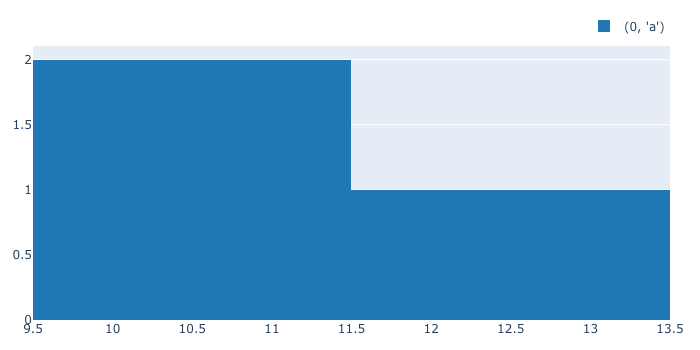

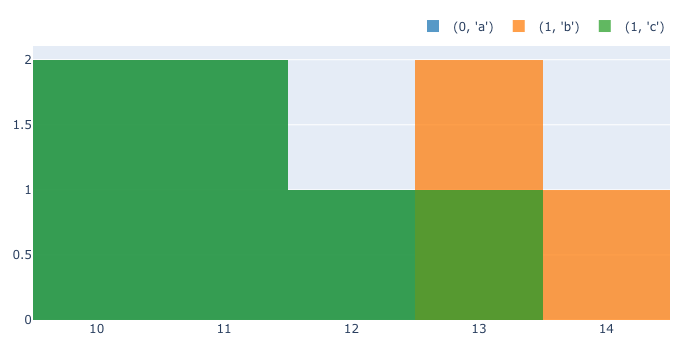

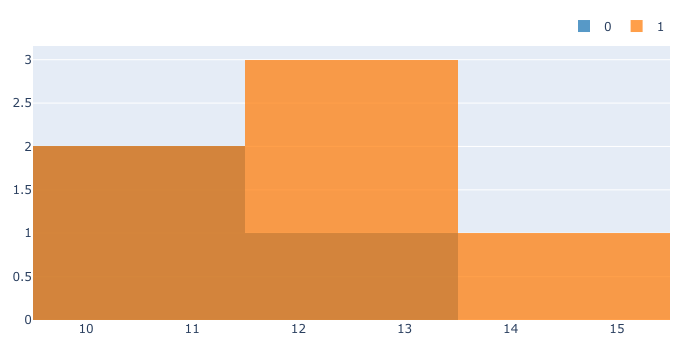

In [55]:
mapped_array[(0, 'a')].hist().show_png()
mapped_array.hist().show_png()
mapped_array_grouped.hist().show_png()

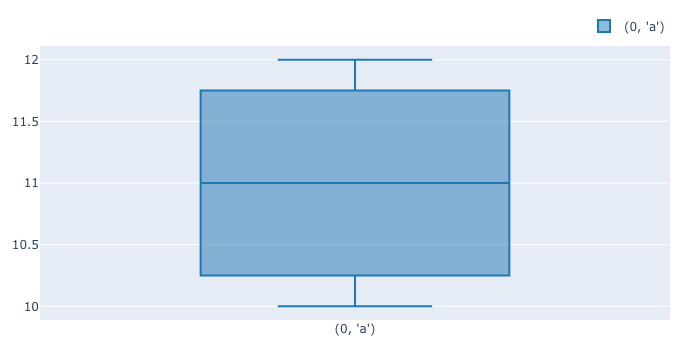

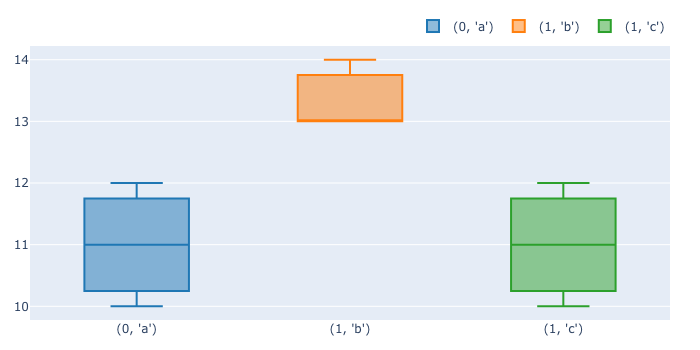

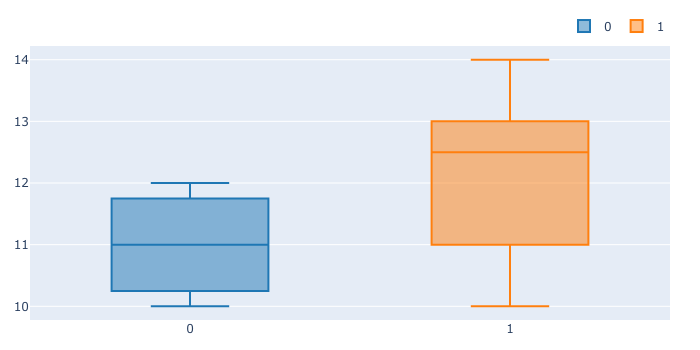

In [56]:
mapped_array[(0, 'a')].box().show_png()
mapped_array.box().show_png()
mapped_array_grouped.box().show_png()

## Records

In [57]:
print(records[(0, 'a')].values)
print(records[(0, 'a')].wrapper.columns)

print(records[(1, 'b')].values)
print(records[(1, 'b')].wrapper.columns)

print(records[[(0, 'a'), (0, 'a')]].values)
print(records[[(0, 'a'), (0, 'a')]].wrapper.columns)

print(records[[(0, 'a'), (1, 'b')]].values)
print(records[[(0, 'a'), (1, 'b')]].wrapper.columns)

%timeit big_records.iloc[0]
%timeit big_records.iloc[:]

[(0, 0, 10., 21.) (0, 1, 11., 20.) (0, 2, 12., 19.)]
MultiIndex([(0, 'a')],
           names=['lvl1', 'lvl2'])
[(0, 0, 13., 18.) (0, 1, 14., 17.) (0, 2, 13., 18.)]
MultiIndex([(1, 'b')],
           names=['lvl1', 'lvl2'])
[(0, 0, 10., 21.) (0, 1, 11., 20.) (0, 2, 12., 19.) (1, 0, 10., 21.)
 (1, 1, 11., 20.) (1, 2, 12., 19.)]
MultiIndex([(0, 'a'),
            (0, 'a')],
           names=['lvl1', 'lvl2'])
[(0, 0, 10., 21.) (0, 1, 11., 20.) (0, 2, 12., 19.) (1, 0, 13., 18.)
 (1, 1, 14., 17.) (1, 2, 13., 18.)]
MultiIndex([(0, 'a'),
            (1, 'b')],
           names=['lvl1', 'lvl2'])
7.78 ms ± 73.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
20.7 ms ± 7.73 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [58]:
print(records_nosort[(0, 'a')].values)
print(records_nosort[(0, 'a')].wrapper.columns)

print(records_nosort[(1, 'b')].values)
print(records_nosort[(1, 'b')].wrapper.columns)

print(records_nosort[[(0, 'a'), (0, 'a')]].values)
print(records_nosort[[(0, 'a'), (0, 'a')]].wrapper.columns)

print(records_nosort[[(0, 'a'), (1, 'b')]].values)
print(records_nosort[[(0, 'a'), (1, 'b')]].wrapper.columns)

%timeit big_records_nosort.iloc[0]
%timeit big_records_nosort.iloc[:]

[(0, 2, 12., 19.) (0, 1, 11., 20.) (0, 0, 10., 21.)]
MultiIndex([(0, 'a')],
           names=['lvl1', 'lvl2'])
[(0, 2, 13., 18.) (0, 1, 14., 17.) (0, 0, 13., 18.)]
MultiIndex([(1, 'b')],
           names=['lvl1', 'lvl2'])
[(0, 2, 12., 19.) (0, 1, 11., 20.) (0, 0, 10., 21.) (1, 2, 12., 19.)
 (1, 1, 11., 20.) (1, 0, 10., 21.)]
MultiIndex([(0, 'a'),
            (0, 'a')],
           names=['lvl1', 'lvl2'])
[(0, 2, 12., 19.) (0, 1, 11., 20.) (0, 0, 10., 21.) (1, 2, 13., 18.)
 (1, 1, 14., 17.) (1, 0, 13., 18.)]
MultiIndex([(0, 'a'),
            (1, 'b')],
           names=['lvl1', 'lvl2'])
20.7 ms ± 717 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
35.3 ms ± 4.64 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [59]:
print(records_grouped[0].wrapper.columns)  # indexing on groups, not columns!
print(records_grouped[0].wrapper.ndim)
print(records_grouped[0].wrapper.grouped_ndim)
print(records_grouped[0].wrapper.grouper.group_by)

print(records_grouped[1].wrapper.columns)
print(records_grouped[1].wrapper.ndim)
print(records_grouped[1].wrapper.grouped_ndim)
print(records_grouped[1].wrapper.grouper.group_by)

print(records_grouped[[0]].wrapper.columns)
print(records_grouped[[0]].wrapper.ndim)
print(records_grouped[[0]].wrapper.grouped_ndim)
print(records_grouped[[0]].wrapper.grouper.group_by)

print(records_grouped[[0, 1]].wrapper.columns)
print(records_grouped[[0, 1]].wrapper.ndim)
print(records_grouped[[0, 1]].wrapper.grouped_ndim)
print(records_grouped[[0, 1]].wrapper.grouper.group_by)

%timeit big_records_grouped.iloc[0]
%timeit big_records_grouped.iloc[:]

MultiIndex([(0, 'a')],
           names=['lvl1', 'lvl2'])
1
1
Int64Index([0], dtype='int64', name='lvl1')
MultiIndex([(1, 'b'),
            (1, 'c'),
            (1, 'd')],
           names=['lvl1', 'lvl2'])
2
1
Int64Index([1, 1, 1], dtype='int64', name='lvl1')
MultiIndex([(0, 'a')],
           names=['lvl1', 'lvl2'])
2
2
Int64Index([0], dtype='int64', name='lvl1')
MultiIndex([(0, 'a'),
            (1, 'b'),
            (1, 'c'),
            (1, 'd')],
           names=['lvl1', 'lvl2'])
2
2
Int64Index([0, 1, 1, 1], dtype='int64', name='lvl1')
18.3 ms ± 1.64 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
18.2 ms ± 381 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [60]:
print(records.wrapper.index)
print(records.wrapper.columns)
print(records.wrapper.ndim)
print(records.wrapper.grouper.group_by)

print(records_grouped.wrapper.index)
print(records_grouped.wrapper.columns)
print(records_grouped.wrapper.ndim)
print(records_grouped.wrapper.grouper.group_by)

Index(['x', 'y', 'z'], dtype='object')
MultiIndex([(0, 'a'),
            (1, 'b'),
            (1, 'c'),
            (1, 'd')],
           names=['lvl1', 'lvl2'])
2
None
Index(['x', 'y', 'z'], dtype='object')
MultiIndex([(0, 'a'),
            (1, 'b'),
            (1, 'c'),
            (1, 'd')],
           names=['lvl1', 'lvl2'])
2
Int64Index([0, 1, 1, 1], dtype='int64', name='lvl1')


In [61]:
print(records.values)

print(records.recarray)
%timeit big_records.recarray

[(0, 0, 10., 21.) (0, 1, 11., 20.) (0, 2, 12., 19.) (1, 0, 13., 18.)
 (1, 1, 14., 17.) (1, 2, 13., 18.) (2, 0, 12., 19.) (2, 1, 11., 20.)
 (2, 2, 10., 21.)]
[(0, 0, 10., 21.) (0, 1, 11., 20.) (0, 2, 12., 19.) (1, 0, 13., 18.)
 (1, 1, 14., 17.) (1, 2, 13., 18.) (2, 0, 12., 19.) (2, 1, 11., 20.)
 (2, 2, 10., 21.)]
5.4 µs ± 54.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [62]:
print(records.records)

   col  idx  some_field1  some_field2
0    0    0         10.0         21.0
1    0    1         11.0         20.0
2    0    2         12.0         19.0
3    1    0         13.0         18.0
4    1    1         14.0         17.0
5    1    2         13.0         18.0
6    2    0         12.0         19.0
7    2    1         11.0         20.0
8    2    2         10.0         21.0


In [63]:
print(records.is_sorted())
%timeit big_records.is_sorted()

print(records_nosort.is_sorted())
%timeit big_records_nosort.is_sorted()

print(records.is_sorted(incl_idx=True))
%timeit big_records.is_sorted(incl_idx=True)

print(records_nosort.is_sorted(incl_idx=True))
%timeit big_records_nosort.is_sorted(incl_idx=True)

True
2.14 ms ± 43.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
False
3.47 µs ± 60 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
True
2.5 ms ± 242 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
False
3.14 µs ± 40.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [64]:
print(records.sort().records_arr)
%timeit big_records.sort()

print(records_nosort.sort().records_arr)
%timeit big_records_nosort.sort()

print(records.sort(incl_idx=True).records_arr)
%timeit big_records.sort(incl_idx=True)

print(records_nosort.sort(incl_idx=True).records_arr)
%timeit big_records_nosort.sort(incl_idx=True)

[(0, 0, 10., 21.) (0, 1, 11., 20.) (0, 2, 12., 19.) (1, 0, 13., 18.)
 (1, 1, 14., 17.) (1, 2, 13., 18.) (2, 0, 12., 19.) (2, 1, 11., 20.)
 (2, 2, 10., 21.)]
2.2 ms ± 51.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
[(0, 2, 12., 19.) (0, 1, 11., 20.) (0, 0, 10., 21.) (1, 2, 13., 18.)
 (1, 1, 14., 17.) (1, 0, 13., 18.) (2, 2, 10., 21.) (2, 1, 11., 20.)
 (2, 0, 12., 19.)]
126 ms ± 27.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
[(0, 0, 10., 21.) (0, 1, 11., 20.) (0, 2, 12., 19.) (1, 0, 13., 18.)
 (1, 1, 14., 17.) (1, 2, 13., 18.) (2, 0, 12., 19.) (2, 1, 11., 20.)
 (2, 2, 10., 21.)]
2.52 ms ± 178 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
[(0, 0, 10., 21.) (0, 1, 11., 20.) (0, 2, 12., 19.) (1, 0, 13., 18.)
 (1, 1, 14., 17.) (1, 2, 13., 18.) (2, 0, 12., 19.) (2, 1, 11., 20.)
 (2, 2, 10., 21.)]
148 ms ± 7.23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [65]:
mask = records.values['some_field1'] >= records.values['some_field1'].mean()
print(records.filter_by_mask(mask).values)

big_mask = big_records.values['some_field1'] >= big_records.values['some_field1'].mean()
%timeit big_records.filter_by_mask(big_mask)

[(0, 2, 12., 19.) (1, 0, 13., 18.) (1, 1, 14., 17.) (1, 2, 13., 18.)
 (2, 0, 12., 19.)]
13.2 ms ± 614 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [66]:
@njit
def map_nb(record):
    return record.some_field1 + record.some_field2 * 2

print(records.map(map_nb).sum())
print(records_grouped.map(map_nb).sum())
print(records_grouped.map(map_nb, group_by=False).sum())

%timeit vbt.records.MappedArray(\
    big_wrapper,\
    big_records_arr['some_field1'] + big_records_arr['some_field2'] * 2,\
    big_records_arr['col'],\
)
%timeit big_records.map(map_nb)  # faster

lvl1  lvl2
0     a       153.0
1     b       146.0
      c       153.0
      d         0.0
dtype: float64
lvl1
0    153.0
1    299.0
dtype: float64
lvl1  lvl2
0     a       153.0
1     b       146.0
      c       153.0
      d         0.0
dtype: float64
8.7 ms ± 74.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.66 ms ± 85.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [67]:
print(records.map_field('col').values)
print(records.map_field('idx').values)
print(records.map_field('some_field1').values)
print(records.map_field('some_field2').values)

print(records.map_field('some_field1').sum())
print(records_grouped.map_field('some_field1').sum())
print(records_grouped.map_field('some_field1', group_by=False).sum())

%timeit big_records.map_field('some_field1')

[0 0 0 1 1 1 2 2 2]
[0 1 2 0 1 2 0 1 2]
[10. 11. 12. 13. 14. 13. 12. 11. 10.]
[21. 20. 19. 18. 17. 18. 19. 20. 21.]
lvl1  lvl2
0     a       33.0
1     b       40.0
      c       33.0
      d        0.0
dtype: float64
lvl1
0    33.0
1    73.0
dtype: float64
lvl1  lvl2
0     a       33.0
1     b       40.0
      c       33.0
      d        0.0
dtype: float64
19.5 µs ± 771 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [68]:
print(records.map_array(records_arr['some_field1'] + records_arr['some_field2'] * 2).values)
print(records_grouped.map_array(records_arr['some_field1'] + records_arr['some_field2'] * 2).sum())
print(records_grouped.map_array(records_arr['some_field1'] + records_arr['some_field2'] * 2, group_by=False).sum())

%timeit big_records.map_array(big_records_arr['some_field1'] + big_records_arr['some_field2'] * 2)

[52. 51. 50. 49. 48. 49. 50. 51. 52.]
lvl1
0    153.0
1    299.0
dtype: float64
lvl1  lvl2
0     a       153.0
1     b       146.0
      c       153.0
      d         0.0
dtype: float64
8.83 ms ± 179 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [69]:
print(records.count())
print(records_grouped.count())
print(records_grouped.count(group_by=False))

%timeit big_records.count()
%timeit big_records_grouped.count()

lvl1  lvl2
0     a       3
1     b       3
      c       3
      d       0
dtype: int64
lvl1
0    3
1    6
dtype: int64
lvl1  lvl2
0     a       3
1     b       3
      c       3
      d       0
dtype: int64
14.8 ms ± 350 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
8.65 ms ± 146 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [70]:
filter_mask = np.array([True, False, False, False, False, False, False, False, True])

print(records.filter_by_mask(filter_mask).count())
print(records_grouped.filter_by_mask(filter_mask).count())
print(records_grouped.filter_by_mask(filter_mask, group_by=False).count())

lvl1  lvl2
0     a       1
1     b       0
      c       1
      d       0
dtype: int64
lvl1
0    1
1    1
dtype: int64
lvl1  lvl2
0     a       1
1     b       0
      c       1
      d       0
dtype: int64


In [72]:
filtered_records = records.filter_by_mask(filter_mask)
print(filtered_records.records)

   col  idx  some_field1  some_field2
0    0    0         10.0         21.0
1    2    2         10.0         21.0


In [73]:
print(filtered_records[(0, 'a')].records)
print(filtered_records[(0, 'a')].map_field('some_field1').values)
print(filtered_records[(0, 'a')].map_field('some_field1').min())
print(filtered_records[(0, 'a')].count())

   col  idx  some_field1  some_field2
0    0    0         10.0         21.0
[10.]
10.0
1


In [74]:
print(filtered_records[(1, 'b')].records)
print(filtered_records[(1, 'b')].map_field('some_field1').values)
print(filtered_records[(1, 'b')].map_field('some_field1').min())
print(filtered_records[(1, 'b')].count())

Empty DataFrame
Columns: [col, idx, some_field1, some_field2]
Index: []
[]
nan
0


In [75]:
print(filtered_records[(1, 'c')].records)
print(filtered_records[(1, 'c')].map_field('some_field1').values)
print(filtered_records[(1, 'c')].map_field('some_field1').min())
print(filtered_records[(1, 'c')].count())

   col  idx  some_field1  some_field2
0    0    2         10.0         21.0
[10.]
10.0
1


In [76]:
print(filtered_records[(1, 'd')].records)
print(filtered_records[(1, 'd')].map_field('some_field1').values)
print(filtered_records[(1, 'd')].map_field('some_field1').min())
print(filtered_records[(1, 'd')].count())

Empty DataFrame
Columns: [col, idx, some_field1, some_field2]
Index: []
[]
nan
0


## Drawdowns

In [9]:
ts = pd.DataFrame({
    'a': [2, 1, 3, 1, 4, 1], 
    'b': [1, 2, 1, 3, 1, 4],
    'c': [1, 2, 3, 2, 1, 2],
    'd': [1, 2, 3, 4, 5, 6]
}, index=[
    datetime(2020, 1, 1),
    datetime(2020, 1, 2),
    datetime(2020, 1, 3),
    datetime(2020, 1, 4),
    datetime(2020, 1, 5),
    datetime(2020, 1, 6)
])

np.random.seed(42)
big_ts = pd.DataFrame(np.random.randint(1, 10, size=(1000, 1000)))

In [10]:
drawdowns = vbt.Drawdowns.from_ts(ts, freq='1 days')
print(drawdowns.values.shape)

(6,)


In [11]:
big_drawdowns = vbt.Drawdowns.from_ts(big_ts, freq='1 days')
print(big_drawdowns.values.shape)

(99845,)


In [80]:
%timeit vbt.Drawdowns.from_ts(big_ts, freq='1 days')

8.46 ms ± 144 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [81]:
print(drawdowns.records)
print(drawdowns.ts)

print(drawdowns['a'].records)
print(drawdowns['a'].ts)

%timeit big_drawdowns.iloc[0]
%timeit big_drawdowns.iloc[:]

   col  start_idx  valley_idx  end_idx  status
0    0          0           1        2       1
1    0          2           3        4       1
2    0          4           5        5       0
3    1          1           2        3       1
4    1          3           4        5       1
5    2          2           4        5       0
            a  b  c  d
2020-01-01  2  1  1  1
2020-01-02  1  2  2  2
2020-01-03  3  1  3  3
2020-01-04  1  3  2  4
2020-01-05  4  1  1  5
2020-01-06  1  4  2  6
   col  start_idx  valley_idx  end_idx  status
0    0          0           1        2       1
1    0          2           3        4       1
2    0          4           5        5       0
2020-01-01    2
2020-01-02    1
2020-01-03    3
2020-01-04    1
2020-01-05    4
2020-01-06    1
Name: a, dtype: int64
1.53 ms ± 68.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
10.1 ms ± 63.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [82]:
print(drawdowns.records_readable)

  Column Start Date Valley Date   End Date     Status
0      a 2020-01-01  2020-01-02 2020-01-03  Recovered
1      a 2020-01-03  2020-01-04 2020-01-05  Recovered
2      a 2020-01-05  2020-01-06 2020-01-06     Active
3      b 2020-01-02  2020-01-03 2020-01-04  Recovered
4      b 2020-01-04  2020-01-05 2020-01-06  Recovered
5      c 2020-01-03  2020-01-05 2020-01-06     Active


In [83]:
print(drawdowns['a'].count())

print(drawdowns.count())
print(drawdowns.count(group_by=group_by))

3
a    3
b    2
c    1
d    0
dtype: int64
group
first     5
second    1
dtype: int64


In [84]:
print(drawdowns['a'].start_value.to_matrix())
print(drawdowns.start_value.to_matrix())

%timeit big_drawdowns.start_value

2020-01-01    NaN
2020-01-02    NaN
2020-01-03    2.0
2020-01-04    NaN
2020-01-05    3.0
2020-01-06    4.0
Name: a, dtype: float64
              a    b    c   d
2020-01-01  NaN  NaN  NaN NaN
2020-01-02  NaN  NaN  NaN NaN
2020-01-03  2.0  NaN  NaN NaN
2020-01-04  NaN  2.0  NaN NaN
2020-01-05  3.0  NaN  NaN NaN
2020-01-06  4.0  3.0  3.0 NaN
1.87 ms ± 41.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [85]:
print(drawdowns['a'].valley_value.to_matrix())
print(drawdowns.valley_value.to_matrix())

%timeit big_drawdowns.valley_value

2020-01-01    NaN
2020-01-02    NaN
2020-01-03    1.0
2020-01-04    NaN
2020-01-05    1.0
2020-01-06    1.0
Name: a, dtype: float64
              a    b    c   d
2020-01-01  NaN  NaN  NaN NaN
2020-01-02  NaN  NaN  NaN NaN
2020-01-03  1.0  NaN  NaN NaN
2020-01-04  NaN  1.0  NaN NaN
2020-01-05  1.0  NaN  NaN NaN
2020-01-06  1.0  1.0  1.0 NaN
1.87 ms ± 31.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [86]:
print(drawdowns['a'].end_value.to_matrix())
print(drawdowns.end_value.to_matrix())

%timeit big_drawdowns.end_value

2020-01-01    NaN
2020-01-02    NaN
2020-01-03    3.0
2020-01-04    NaN
2020-01-05    4.0
2020-01-06    1.0
Name: a, dtype: float64
              a    b    c   d
2020-01-01  NaN  NaN  NaN NaN
2020-01-02  NaN  NaN  NaN NaN
2020-01-03  3.0  NaN  NaN NaN
2020-01-04  NaN  3.0  NaN NaN
2020-01-05  4.0  NaN  NaN NaN
2020-01-06  1.0  4.0  2.0 NaN
1.86 ms ± 28.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [87]:
print(drawdowns['a'].drawdown.to_matrix())
print(drawdowns.drawdown.to_matrix())

%timeit big_drawdowns.drawdown

2020-01-01         NaN
2020-01-02         NaN
2020-01-03   -0.500000
2020-01-04         NaN
2020-01-05   -0.666667
2020-01-06   -0.750000
Name: a, dtype: float64
                   a         b         c   d
2020-01-01       NaN       NaN       NaN NaN
2020-01-02       NaN       NaN       NaN NaN
2020-01-03 -0.500000       NaN       NaN NaN
2020-01-04       NaN -0.500000       NaN NaN
2020-01-05 -0.666667       NaN       NaN NaN
2020-01-06 -0.750000 -0.666667 -0.666667 NaN
3.74 ms ± 21.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [88]:
print(drawdowns['a'].avg_drawdown())
print(drawdowns.avg_drawdown())
%timeit big_drawdowns.avg_drawdown()

print(drawdowns.avg_drawdown(group_by=group_by))
%timeit big_drawdowns.avg_drawdown(group_by=big_group_by)

-0.6388888888888888
a   -0.638889
b   -0.583333
c   -0.666667
d    0.000000
dtype: float64
9.15 ms ± 208 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
group
first    -0.616667
second   -0.666667
dtype: float64
6.72 ms ± 75.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [89]:
print(drawdowns['a'].max_drawdown())
print(drawdowns.max_drawdown())
%timeit big_drawdowns.max_drawdown()

print(drawdowns.max_drawdown(group_by=group_by))
%timeit big_drawdowns.max_drawdown(group_by=big_group_by)

-0.75
a   -0.750000
b   -0.666667
c   -0.666667
d    0.000000
dtype: float64
10.5 ms ± 2.29 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
group
first    -0.750000
second   -0.666667
dtype: float64
7.28 ms ± 574 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [90]:
print(drawdowns['a'].duration.to_matrix())
print(drawdowns.duration.to_matrix())

%timeit big_drawdowns.duration

2020-01-01    NaN
2020-01-02    NaN
2020-01-03    2.0
2020-01-04    NaN
2020-01-05    2.0
2020-01-06    1.0
Name: a, dtype: float64
              a    b    c   d
2020-01-01  NaN  NaN  NaN NaN
2020-01-02  NaN  NaN  NaN NaN
2020-01-03  2.0  NaN  NaN NaN
2020-01-04  NaN  2.0  NaN NaN
2020-01-05  2.0  NaN  NaN NaN
2020-01-06  1.0  2.0  3.0 NaN
907 µs ± 93 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [91]:
print(drawdowns['a'].avg_duration())
print(drawdowns.avg_duration())
%timeit big_drawdowns.avg_duration()

print(drawdowns.avg_duration(group_by=group_by))
%timeit big_drawdowns.avg_duration(group_by=big_group_by)

1 days 16:00:00
a   1 days 16:00:00
b   2 days 00:00:00
c   3 days 00:00:00
d               NaT
dtype: timedelta64[ns]
6.05 ms ± 146 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
group
first    1 days 19:12:00
second   3 days 00:00:00
dtype: timedelta64[ns]
3.76 ms ± 40.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [92]:
print(drawdowns['a'].max_duration())
print(drawdowns.max_duration())
%timeit big_drawdowns.max_duration()

print(drawdowns.max_duration(group_by=group_by))
%timeit big_drawdowns.max_duration(group_by=big_group_by)

2 days 00:00:00
a   2 days
b   2 days
c   3 days
d      NaT
dtype: timedelta64[ns]
6.03 ms ± 35.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
group
first    2 days
second   3 days
dtype: timedelta64[ns]
3.73 ms ± 31 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [93]:
print(drawdowns['a'].coverage())
print(drawdowns.coverage())
%timeit big_drawdowns.coverage()

print(drawdowns.coverage(group_by=group_by))
%timeit big_drawdowns.coverage(group_by=big_group_by)

0.8333333333333334
a    0.833333
b    0.666667
c    0.500000
d    0.000000
dtype: float64
6.34 ms ± 150 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
group
first     0.75
second    0.25
dtype: float64
4.52 ms ± 104 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [94]:
print(drawdowns['a'].ptv_duration.to_matrix())
print(drawdowns.ptv_duration.to_matrix())

%timeit big_drawdowns.ptv_duration

2020-01-01    NaN
2020-01-02    NaN
2020-01-03    1.0
2020-01-04    NaN
2020-01-05    1.0
2020-01-06    1.0
Name: a, dtype: float64
              a    b    c   d
2020-01-01  NaN  NaN  NaN NaN
2020-01-02  NaN  NaN  NaN NaN
2020-01-03  1.0  NaN  NaN NaN
2020-01-04  NaN  1.0  NaN NaN
2020-01-05  1.0  NaN  NaN NaN
2020-01-06  1.0  1.0  2.0 NaN
773 µs ± 6.61 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [95]:
print(drawdowns['a'].status.to_matrix())
print(drawdowns.status.to_matrix())

%timeit big_drawdowns.status

2020-01-01    NaN
2020-01-02    NaN
2020-01-03    1.0
2020-01-04    NaN
2020-01-05    1.0
2020-01-06    0.0
Name: a, dtype: float64
              a    b    c   d
2020-01-01  NaN  NaN  NaN NaN
2020-01-02  NaN  NaN  NaN NaN
2020-01-03  1.0  NaN  NaN NaN
2020-01-04  NaN  1.0  NaN NaN
2020-01-05  1.0  NaN  NaN NaN
2020-01-06  0.0  1.0  0.0 NaN
21.5 µs ± 456 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [96]:
print(drawdowns.active)
print(drawdowns['a'].active.records)
print(drawdowns.active['a'].records)
print(drawdowns.active.records)

%timeit big_drawdowns.active

   col  start_idx  valley_idx  end_idx  status
0    0          4           5        5       0
   col  start_idx  valley_idx  end_idx  status
0    0          4           5        5       0
   col  start_idx  valley_idx  end_idx  status
0    0          4           5        5       0
1    2          2           4        5       0
419 µs ± 46 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [97]:
print(drawdowns['a'].active_rate())
print(drawdowns.active_rate())
%timeit big_drawdowns.active_rate()

print(drawdowns.active_rate(group_by=group_by))
%timeit big_drawdowns.active_rate(group_by=big_group_by)

0.3333333333333333
a    0.333333
b    0.000000
c    1.000000
d         NaN
dtype: float64


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/generic/drawdowns.py:183: RuntimeWarning:

invalid value encountered in true_divide



5.3 ms ± 65.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
group
first     0.2
second    1.0
dtype: float64
4.65 ms ± 106 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [98]:
print(drawdowns.recovered)
print(drawdowns['a'].recovered.records)
print(drawdowns.recovered['a'].records)
print(drawdowns.recovered.records)

%timeit big_drawdowns.recovered

   col  start_idx  valley_idx  end_idx  status
0    0          0           1        2       1
1    0          2           3        4       1
   col  start_idx  valley_idx  end_idx  status
0    0          0           1        2       1
1    0          2           3        4       1
   col  start_idx  valley_idx  end_idx  status
0    0          0           1        2       1
1    0          2           3        4       1
2    1          1           2        3       1
3    1          3           4        5       1
2.38 ms ± 36.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [99]:
print(drawdowns['a'].recovered_rate())
print(drawdowns.recovered_rate())
%timeit big_drawdowns.recovered_rate()

print(drawdowns.recovered_rate(group_by=group_by))
%timeit big_drawdowns.recovered_rate(group_by=big_group_by)

0.6666666666666666
a    0.666667
b    1.000000
c    0.000000
d         NaN
dtype: float64


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/generic/drawdowns.py:196: RuntimeWarning:

invalid value encountered in true_divide



11.5 ms ± 349 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
group
first     0.8
second    0.0
dtype: float64
7.57 ms ± 65.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [100]:
print(drawdowns['a'].current_drawdown())
print(drawdowns.current_drawdown())

%timeit big_drawdowns.current_drawdown()

-0.75
a   -0.750000
b         NaN
c   -0.333333
d         NaN
dtype: float64
2.78 ms ± 101 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [101]:
print(drawdowns['a'].current_duration())
print(drawdowns.current_duration())

%timeit big_drawdowns.current_duration()

1 days 00:00:00
a   1 days
b      NaT
c   3 days
d      NaT
dtype: timedelta64[ns]
1.07 ms ± 32.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [102]:
print(drawdowns['a'].current_return())
print(drawdowns.current_return())

%timeit big_drawdowns.current_return()

0.0
a    0.0
b    NaN
c    1.0
d    NaN
dtype: float64
1.11 ms ± 29.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [103]:
print(drawdowns['a'].recovery_return.to_matrix())
print(drawdowns.recovery_return.to_matrix())

%timeit big_drawdowns.recovery_return

2020-01-01    NaN
2020-01-02    NaN
2020-01-03    2.0
2020-01-04    NaN
2020-01-05    3.0
2020-01-06    NaN
Name: a, dtype: float64
              a    b   c   d
2020-01-01  NaN  NaN NaN NaN
2020-01-02  NaN  NaN NaN NaN
2020-01-03  2.0  NaN NaN NaN
2020-01-04  NaN  2.0 NaN NaN
2020-01-05  3.0  NaN NaN NaN
2020-01-06  NaN  3.0 NaN NaN
6.27 ms ± 54.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [104]:
print(drawdowns['a'].vtr_duration.to_matrix())
print(drawdowns.vtr_duration.to_matrix())

%timeit big_drawdowns.vtr_duration

2020-01-01    NaN
2020-01-02    NaN
2020-01-03    1.0
2020-01-04    NaN
2020-01-05    1.0
2020-01-06    NaN
Name: a, dtype: float64
              a    b   c   d
2020-01-01  NaN  NaN NaN NaN
2020-01-02  NaN  NaN NaN NaN
2020-01-03  1.0  NaN NaN NaN
2020-01-04  NaN  1.0 NaN NaN
2020-01-05  1.0  NaN NaN NaN
2020-01-06  NaN  1.0 NaN NaN
3.29 ms ± 24.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [105]:
print(drawdowns['a'].vtr_duration_ratio.to_matrix())
print(drawdowns.vtr_duration_ratio.to_matrix())

%timeit big_drawdowns.vtr_duration_ratio

2020-01-01    NaN
2020-01-02    NaN
2020-01-03    0.5
2020-01-04    NaN
2020-01-05    0.5
2020-01-06    NaN
Name: a, dtype: float64
              a    b   c   d
2020-01-01  NaN  NaN NaN NaN
2020-01-02  NaN  NaN NaN NaN
2020-01-03  0.5  NaN NaN NaN
2020-01-04  NaN  0.5 NaN NaN
2020-01-05  0.5  NaN NaN NaN
2020-01-06  NaN  0.5 NaN NaN
3.37 ms ± 54.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


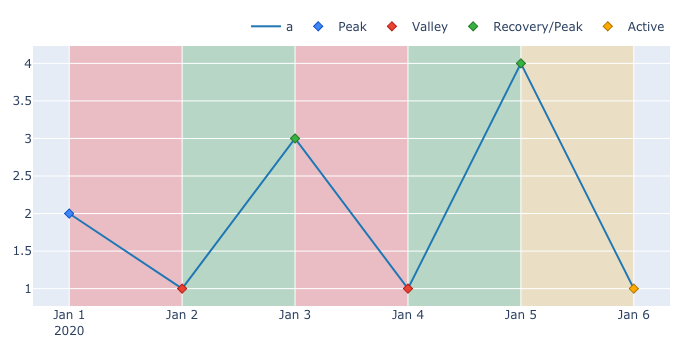

In [12]:
drawdowns['a'].plot().show_png()

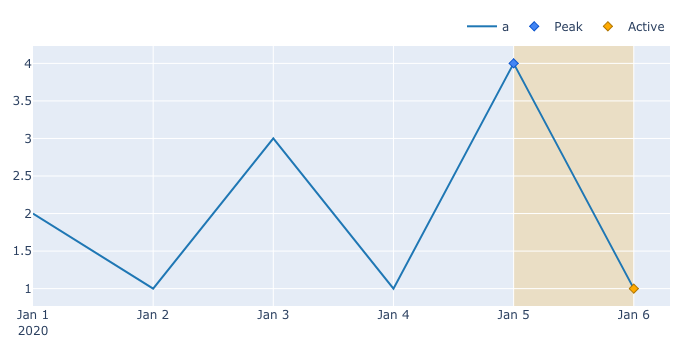

In [13]:
drawdowns.plot(column='a', top_n=1).show_png()

## Orders

In [14]:
close = pd.Series([1, 2, 3, 4, 5, 6, 7, 8], index=[
    datetime(2020, 1, 1),
    datetime(2020, 1, 2),
    datetime(2020, 1, 3),
    datetime(2020, 1, 4),
    datetime(2020, 1, 5),
    datetime(2020, 1, 6),
    datetime(2020, 1, 7),
    datetime(2020, 1, 8)
]).vbt.tile(4, keys=['a', 'b', 'c', 'd'])
print(close)

big_close = pd.DataFrame(np.random.uniform(1, 10, size=(1000, 1000)))

            a  b  c  d
2020-01-01  1  1  1  1
2020-01-02  2  2  2  2
2020-01-03  3  3  3  3
2020-01-04  4  4  4  4
2020-01-05  5  5  5  5
2020-01-06  6  6  6  6
2020-01-07  7  7  7  7
2020-01-08  8  8  8  8


In [15]:
from vectorbt.portfolio.enums import order_dt

records_arr = np.asarray([
    (0, 0, 1. , 1., 0.01 , 0), (0, 1, 0.1, 2., 0.002, 0),
    (0, 2, 1. , 3., 0.03 , 1), (0, 3, 0.1, 4., 0.004, 1),
    (0, 5, 1. , 6., 0.06 , 0), (0, 6, 1. , 7., 0.07 , 1),
    (0, 7, 2. , 8., 0.16 , 0), (1, 0, 1. , 1., 0.01 , 1),
    (1, 1, 0.1, 2., 0.002, 1), (1, 2, 1. , 3., 0.03 , 0),
    (1, 3, 0.1, 4., 0.004, 0), (1, 5, 1. , 6., 0.06 , 1),
    (1, 6, 1. , 7., 0.07 , 0), (1, 7, 2. , 8., 0.16 , 1),
    (2, 0, 1. , 1., 0.01 , 0), (2, 1, 0.1, 2., 0.002, 0),
    (2, 2, 1. , 3., 0.03 , 1), (2, 3, 0.1, 4., 0.004, 1),
    (2, 5, 1. , 6., 0.06 , 0), (2, 6, 2. , 7., 0.14 , 1),
    (2, 7, 2. , 8., 0.16 , 0)
], dtype=order_dt)
print(records_arr.shape)

wrapper = vbt.ArrayWrapper.from_obj(close, freq='1 days')
orders = vbt.Orders(wrapper, records_arr, close)
orders_grouped = vbt.Orders(wrapper.regroup(group_by), records_arr, close)

(21,)


In [16]:
big_records_arr = np.asarray(list(zip(*(
    np.repeat(np.arange(1000), 1000),
    np.tile(np.arange(1000), 1000),
    np.full(1000000, 10),
    np.random.uniform(1, 10, size=1000000),
    np.full(1000000, 1),
    np.full(1000000, 1)
))), dtype=order_dt)
big_records_arr['side'][::2] = 0
print(big_records_arr.shape)

big_wrapper = vbt.ArrayWrapper.from_obj(big_close, freq='1 days')
big_orders = vbt.Orders(big_wrapper, big_records_arr, big_close)
big_orders_grouped = vbt.Orders(big_wrapper.copy(group_by=big_group_by), big_records_arr, big_close)

(1000000,)


In [17]:
print(orders.records)
print(orders.close)

print(orders['a'].records)
print(orders['a'].close)

%timeit big_orders.iloc[0]
%timeit big_orders.iloc[:]

%timeit big_orders_grouped.iloc[0]
%timeit big_orders_grouped.iloc[:]

    col  idx  size  price   fees  side
0     0    0   1.0    1.0  0.010     0
1     0    1   0.1    2.0  0.002     0
2     0    2   1.0    3.0  0.030     1
3     0    3   0.1    4.0  0.004     1
4     0    5   1.0    6.0  0.060     0
5     0    6   1.0    7.0  0.070     1
6     0    7   2.0    8.0  0.160     0
7     1    0   1.0    1.0  0.010     1
8     1    1   0.1    2.0  0.002     1
9     1    2   1.0    3.0  0.030     0
10    1    3   0.1    4.0  0.004     0
11    1    5   1.0    6.0  0.060     1
12    1    6   1.0    7.0  0.070     0
13    1    7   2.0    8.0  0.160     1
14    2    0   1.0    1.0  0.010     0
15    2    1   0.1    2.0  0.002     0
16    2    2   1.0    3.0  0.030     1
17    2    3   0.1    4.0  0.004     1
18    2    5   1.0    6.0  0.060     0
19    2    6   2.0    7.0  0.140     1
20    2    7   2.0    8.0  0.160     0
            a  b  c  d
2020-01-01  1  1  1  1
2020-01-02  2  2  2  2
2020-01-03  3  3  3  3
2020-01-04  4  4  4  4
2020-01-05  5  5  5  5
2020

In [18]:
print(orders.records_readable)

   Column       Date  Size  Price   Fees  Side
0       a 2020-01-01   1.0    1.0  0.010   Buy
1       a 2020-01-02   0.1    2.0  0.002   Buy
2       a 2020-01-03   1.0    3.0  0.030  Sell
3       a 2020-01-04   0.1    4.0  0.004  Sell
4       a 2020-01-06   1.0    6.0  0.060   Buy
5       a 2020-01-07   1.0    7.0  0.070  Sell
6       a 2020-01-08   2.0    8.0  0.160   Buy
7       b 2020-01-01   1.0    1.0  0.010  Sell
8       b 2020-01-02   0.1    2.0  0.002  Sell
9       b 2020-01-03   1.0    3.0  0.030   Buy
10      b 2020-01-04   0.1    4.0  0.004   Buy
11      b 2020-01-06   1.0    6.0  0.060  Sell
12      b 2020-01-07   1.0    7.0  0.070   Buy
13      b 2020-01-08   2.0    8.0  0.160  Sell
14      c 2020-01-01   1.0    1.0  0.010   Buy
15      c 2020-01-02   0.1    2.0  0.002   Buy
16      c 2020-01-03   1.0    3.0  0.030  Sell
17      c 2020-01-04   0.1    4.0  0.004  Sell
18      c 2020-01-06   1.0    6.0  0.060   Buy
19      c 2020-01-07   2.0    7.0  0.140  Sell
20      c 202

In [19]:
print(orders['a'].size.to_matrix())
print(orders.size.to_matrix())

%timeit big_orders.size

2020-01-01    1.0
2020-01-02    0.1
2020-01-03    1.0
2020-01-04    0.1
2020-01-05    NaN
2020-01-06    1.0
2020-01-07    1.0
2020-01-08    2.0
Name: a, dtype: float64
              a    b    c   d
2020-01-01  1.0  1.0  1.0 NaN
2020-01-02  0.1  0.1  0.1 NaN
2020-01-03  1.0  1.0  1.0 NaN
2020-01-04  0.1  0.1  0.1 NaN
2020-01-05  NaN  NaN  NaN NaN
2020-01-06  1.0  1.0  1.0 NaN
2020-01-07  1.0  1.0  2.0 NaN
2020-01-08  2.0  2.0  2.0 NaN
21.1 µs ± 340 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [20]:
print(orders['a'].price.to_matrix())
print(orders.price.to_matrix())

%timeit big_orders.price

2020-01-01    1.0
2020-01-02    2.0
2020-01-03    3.0
2020-01-04    4.0
2020-01-05    NaN
2020-01-06    6.0
2020-01-07    7.0
2020-01-08    8.0
Name: a, dtype: float64
              a    b    c   d
2020-01-01  1.0  1.0  1.0 NaN
2020-01-02  2.0  2.0  2.0 NaN
2020-01-03  3.0  3.0  3.0 NaN
2020-01-04  4.0  4.0  4.0 NaN
2020-01-05  NaN  NaN  NaN NaN
2020-01-06  6.0  6.0  6.0 NaN
2020-01-07  7.0  7.0  7.0 NaN
2020-01-08  8.0  8.0  8.0 NaN
21.4 µs ± 662 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [21]:
print(orders['a'].fees.to_matrix())
print(orders.fees.to_matrix())

%timeit big_orders.fees

2020-01-01    0.010
2020-01-02    0.002
2020-01-03    0.030
2020-01-04    0.004
2020-01-05      NaN
2020-01-06    0.060
2020-01-07    0.070
2020-01-08    0.160
Name: a, dtype: float64
                a      b      c   d
2020-01-01  0.010  0.010  0.010 NaN
2020-01-02  0.002  0.002  0.002 NaN
2020-01-03  0.030  0.030  0.030 NaN
2020-01-04  0.004  0.004  0.004 NaN
2020-01-05    NaN    NaN    NaN NaN
2020-01-06  0.060  0.060  0.060 NaN
2020-01-07  0.070  0.070  0.140 NaN
2020-01-08  0.160  0.160  0.160 NaN
28.7 µs ± 9.28 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [22]:
print(orders['a'].side.to_matrix())
print(orders.side.to_matrix())

%timeit big_orders.side

2020-01-01    0.0
2020-01-02    0.0
2020-01-03    1.0
2020-01-04    1.0
2020-01-05    NaN
2020-01-06    0.0
2020-01-07    1.0
2020-01-08    0.0
Name: a, dtype: float64
              a    b    c   d
2020-01-01  0.0  1.0  0.0 NaN
2020-01-02  0.0  1.0  0.0 NaN
2020-01-03  1.0  0.0  1.0 NaN
2020-01-04  1.0  0.0  1.0 NaN
2020-01-05  NaN  NaN  NaN NaN
2020-01-06  0.0  1.0  0.0 NaN
2020-01-07  1.0  0.0  1.0 NaN
2020-01-08  0.0  1.0  0.0 NaN
21.3 µs ± 632 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [23]:
print(orders.buy)
print(orders['a'].buy.records)
print(orders.buy['a'].records)
print(orders.buy.records)

%timeit big_orders.buy

   col  idx  size  price   fees  side
0    0    0   1.0    1.0  0.010     0
1    0    1   0.1    2.0  0.002     0
2    0    5   1.0    6.0  0.060     0
3    0    7   2.0    8.0  0.160     0
   col  idx  size  price   fees  side
0    0    0   1.0    1.0  0.010     0
1    0    1   0.1    2.0  0.002     0
2    0    5   1.0    6.0  0.060     0
3    0    7   2.0    8.0  0.160     0
    col  idx  size  price   fees  side
0     0    0   1.0    1.0  0.010     0
1     0    1   0.1    2.0  0.002     0
2     0    5   1.0    6.0  0.060     0
3     0    7   2.0    8.0  0.160     0
4     1    2   1.0    3.0  0.030     0
5     1    3   0.1    4.0  0.004     0
6     1    6   1.0    7.0  0.070     0
7     2    0   1.0    1.0  0.010     0
8     2    1   0.1    2.0  0.002     0
9     2    5   1.0    6.0  0.060     0
10    2    7   2.0    8.0  0.160     0
12.5 ms ± 556 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [24]:
print(orders['a'].buy_rate())
print(orders.buy_rate())
%timeit big_orders.buy_rate()

print(orders.buy_rate(group_by=group_by))
%timeit big_orders.buy_rate(group_by=big_group_by)

0.5714285714285714
a    0.571429
b    0.428571
c    0.571429
d         NaN
dtype: float64


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio/orders.py:118: RuntimeWarning:

invalid value encountered in true_divide



39.2 ms ± 4.44 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
group
first     0.500000
second    0.571429
dtype: float64
30.1 ms ± 295 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [25]:
print(orders.sell)
print(orders['a'].sell.records)
print(orders.sell['a'].records)
print(orders.sell.records)

%timeit big_orders.sell

   col  idx  size  price   fees  side
0    0    2   1.0    3.0  0.030     1
1    0    3   0.1    4.0  0.004     1
2    0    6   1.0    7.0  0.070     1
   col  idx  size  price   fees  side
0    0    2   1.0    3.0  0.030     1
1    0    3   0.1    4.0  0.004     1
2    0    6   1.0    7.0  0.070     1
   col  idx  size  price   fees  side
0    0    2   1.0    3.0  0.030     1
1    0    3   0.1    4.0  0.004     1
2    0    6   1.0    7.0  0.070     1
3    1    0   1.0    1.0  0.010     1
4    1    1   0.1    2.0  0.002     1
5    1    5   1.0    6.0  0.060     1
6    1    7   2.0    8.0  0.160     1
7    2    2   1.0    3.0  0.030     1
8    2    3   0.1    4.0  0.004     1
9    2    6   2.0    7.0  0.140     1
22.8 ms ± 1.97 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [26]:
print(orders['a'].sell_rate())
print(orders.sell_rate())
%timeit big_orders.sell_rate()

print(orders.sell_rate(group_by=group_by))
%timeit big_orders.sell_rate(group_by=big_group_by)

0.42857142857142855
a    0.428571
b    0.571429
c    0.428571
d         NaN
dtype: float64


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio/orders.py:131: RuntimeWarning:

invalid value encountered in true_divide



35.5 ms ± 548 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
group
first     0.500000
second    0.428571
dtype: float64
30.5 ms ± 324 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


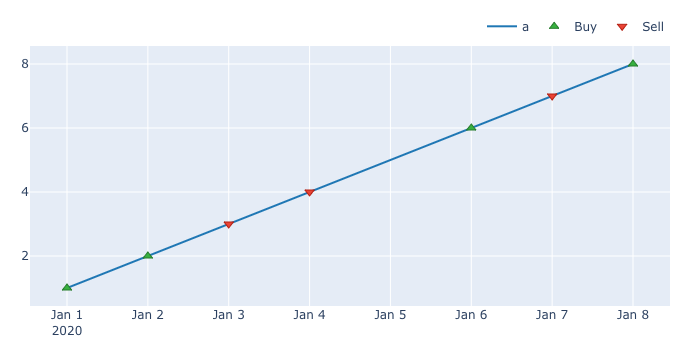

In [27]:
orders['a'].plot().show_png()

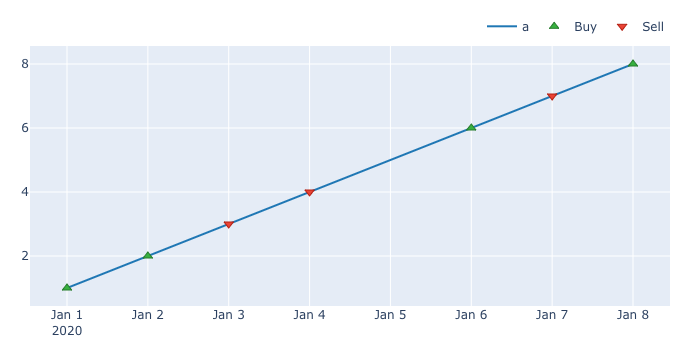

In [28]:
orders.plot(column='a').show_png()

## Trades

In [29]:
trades = vbt.Trades.from_orders(orders)
trades_grouped = vbt.Trades.from_orders(orders_grouped)
print(trades.values.shape)

(13,)


In [30]:
big_trades = vbt.Trades.from_orders(big_orders)
big_trades_grouped = vbt.Trades.from_orders(big_orders_grouped)
print(big_trades.values.shape)

(500000,)


In [31]:
%timeit vbt.Trades.from_orders(big_orders)

36.7 ms ± 7.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [32]:
print(trades.records)
print(trades.close)

print(trades['a'].records)
print(trades['a'].close)

%timeit big_trades.iloc[0]
%timeit big_trades.iloc[:]

%timeit big_trades_grouped.iloc[0]
%timeit big_trades_grouped.iloc[:]

    col  size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0     0   1.0          0     1.090909    0.010909         2         3.0   
1     0   0.1          0     1.090909    0.001091         3         4.0   
2     0   1.0          5     6.000000    0.060000         6         7.0   
3     0   2.0          7     8.000000    0.160000         7         8.0   
4     1   1.0          0     1.090909    0.010909         2         3.0   
5     1   0.1          0     1.090909    0.001091         3         4.0   
6     1   1.0          5     6.000000    0.060000         6         7.0   
7     1   2.0          7     8.000000    0.160000         7         8.0   
8     2   1.0          0     1.090909    0.010909         2         3.0   
9     2   0.1          0     1.090909    0.001091         3         4.0   
10    2   1.0          5     6.000000    0.060000         6         7.0   
11    2   1.0          6     7.000000    0.070000         7         8.0   
12    2   1.0          7 

In [33]:
print(trades.records_readable)

   Column  Size Entry Date  Entry Price  Entry Fees  Exit Date  Exit Price  \
0       a   1.0 2020-01-01     1.090909    0.010909 2020-01-03         3.0   
1       a   0.1 2020-01-01     1.090909    0.001091 2020-01-04         4.0   
2       a   1.0 2020-01-06     6.000000    0.060000 2020-01-07         7.0   
3       a   2.0 2020-01-08     8.000000    0.160000 2020-01-08         8.0   
4       b   1.0 2020-01-01     1.090909    0.010909 2020-01-03         3.0   
5       b   0.1 2020-01-01     1.090909    0.001091 2020-01-04         4.0   
6       b   1.0 2020-01-06     6.000000    0.060000 2020-01-07         7.0   
7       b   2.0 2020-01-08     8.000000    0.160000 2020-01-08         8.0   
8       c   1.0 2020-01-01     1.090909    0.010909 2020-01-03         3.0   
9       c   0.1 2020-01-01     1.090909    0.001091 2020-01-04         4.0   
10      c   1.0 2020-01-06     6.000000    0.060000 2020-01-07         7.0   
11      c   1.0 2020-01-07     7.000000    0.070000 2020-01-08  

In [34]:
print(trades['a'].count())
print(trades.count())
%timeit big_trades.count()

print(trades_grouped.count())
%timeit big_trades_grouped.count()

4
a    4
b    4
c    5
d    0
dtype: int64
12 ms ± 96.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
group
first     8
second    5
dtype: int64
10.8 ms ± 2.21 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [35]:
print(trades['a'].duration.stack())
print(trades.duration.stack())

%timeit big_trades.duration

0    2.0
1    3.0
2    1.0
3    0.0
Name: a, dtype: float64
     a    b    c   d
0  2.0  2.0  2.0 NaN
1  3.0  3.0  3.0 NaN
2  1.0  1.0  1.0 NaN
3  0.0  0.0  1.0 NaN
4  NaN  NaN  0.0 NaN
5.71 ms ± 138 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [36]:
print(trades['a'].pnl.stack())
print(trades.pnl.stack())

%timeit big_trades.pnl

0    1.868182
1    0.285818
2    0.870000
3   -0.160000
Name: a, dtype: float64
          a      b         c   d
0  1.868182 -1.950  1.868182 NaN
1  0.285818 -0.296  0.285818 NaN
2  0.870000 -1.130  0.870000 NaN
3 -0.160000 -0.160 -1.150000 NaN
4       NaN    NaN -0.080000 NaN
21.4 µs ± 309 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [37]:
print(trades['a'].returns.stack())
print(trades.returns.stack())

%timeit big_trades.returns

0    1.7125
1    2.6200
2    0.1450
3   -0.0100
Name: a, dtype: float64
        a         b         c   d
0  1.7125 -1.787500  1.712500 NaN
1  2.6200 -2.713333  2.620000 NaN
2  0.1450 -0.188333  0.145000 NaN
3 -0.0100 -0.010000 -0.164286 NaN
4     NaN       NaN -0.010000 NaN
24 µs ± 3.04 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [38]:
print(trades['a'].position_idx.stack())
print(trades.position_idx.stack())

%timeit big_trades.position_idx

0    0
1    0
2    1
3    2
Name: a, dtype: int64
     a    b    c   d
0  0.0  0.0  0.0 NaN
1  0.0  0.0  0.0 NaN
2  1.0  1.0  1.0 NaN
3  2.0  2.0  2.0 NaN
4  NaN  NaN  3.0 NaN
22.1 µs ± 1.45 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [39]:
print(trades.winning)
print(trades['a'].winning.records)
print(trades.winning['a'].records)
print(trades.winning.records)

%timeit big_trades.winning

   col  size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0    0   1.0          0     1.090909    0.010909         2         3.0   
1    0   0.1          0     1.090909    0.001091         3         4.0   
2    0   1.0          5     6.000000    0.060000         6         7.0   

   exit_fees       pnl  return  direction  status  position_idx  
0      0.030  1.868182  1.7125          0       1             0  
1      0.004  0.285818  2.6200          0       1             0  
2      0.070  0.870000  0.1450          0       1             1  
   col  size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0    0   1.0          0     1.090909    0.010909         2         3.0   
1    0   0.1          0     1.090909    0.001091         3         4.0   
2    0   1.0          5     6.000000    0.060000         6         7.0   

   exit_fees       pnl  return  direction  status  position_idx  
0      0.030  1.868182  1.7125          0       1             0  
1      0.0

In [40]:
print(trades['a'].win_rate())
print(trades.win_rate())
%timeit big_trades.win_rate()

print(trades.win_rate(group_by=group_by))
%timeit big_trades.win_rate(group_by=big_group_by)

0.75
a    0.75
b    0.00
c    0.60
d     NaN
dtype: float64


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio/trades.py:223: RuntimeWarning:

invalid value encountered in true_divide



32.4 ms ± 271 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
group
first     0.375
second    0.600
dtype: float64
25.9 ms ± 517 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [41]:
print(trades.losing)
print(trades['a'].losing.records)
print(trades.losing['a'].records)
print(trades.losing.records)

%timeit big_trades.losing

   col  size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0    0   2.0          7          8.0        0.16         7         8.0   

   exit_fees   pnl  return  direction  status  position_idx  
0        0.0 -0.16   -0.01          0       0             2  
   col  size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0    0   2.0          7          8.0        0.16         7         8.0   

   exit_fees   pnl  return  direction  status  position_idx  
0        0.0 -0.16   -0.01          0       0             2  
   col  size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0    0   2.0          7     8.000000    0.160000         7         8.0   
1    1   1.0          0     1.090909    0.010909         2         3.0   
2    1   0.1          0     1.090909    0.001091         3         4.0   
3    1   1.0          5     6.000000    0.060000         6         7.0   
4    1   2.0          7     8.000000    0.160000         7         8.0   
5    2   1

In [42]:
print(trades['a'].loss_rate())
print(trades.loss_rate())
%timeit big_trades.loss_rate()

print(trades.loss_rate(group_by=group_by))
%timeit big_trades.loss_rate(group_by=big_group_by)

0.25
a    0.25
b    1.00
c    0.40
d     NaN
dtype: float64


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio/trades.py:236: RuntimeWarning:

invalid value encountered in true_divide



32.9 ms ± 372 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
group
first     0.625
second    0.400
dtype: float64
26.5 ms ± 1.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [43]:
print(trades['a'].profit_factor())
print(trades.profit_factor())
%timeit big_trades.profit_factor()

print(trades_grouped.profit_factor())
%timeit big_trades_grouped.profit_factor()

18.9


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio/trades.py:249: RuntimeWarning:

invalid value encountered in true_divide



a    18.900000
b     0.000000
c     2.458537
d          NaN
dtype: float64
63.6 ms ± 523 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
group
first     0.818182
second    2.458537
dtype: float64
57.1 ms ± 798 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [44]:
print(trades['a'].expectancy())
print(trades.expectancy())
%timeit big_trades.expectancy()

print(trades_grouped.expectancy())
%timeit big_trades_grouped.expectancy()

0.716


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio/trades.py:223: RuntimeWarning:

invalid value encountered in true_divide



a    0.7160
b   -0.8840
c    0.3588
d       NaN
dtype: float64
105 ms ± 704 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
group
first    -0.0840
second    0.3588
dtype: float64
92.8 ms ± 1.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [45]:
print(trades['a'].sqn())
print(trades.sqn())
%timeit big_trades.sqn()

print(trades_grouped.sqn())
%timeit big_trades_grouped.sqn()

1.634155521947584
a    1.634156
b   -2.130073
c    0.716604
d         NaN
dtype: float64
48.7 ms ± 477 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
group
first    -0.204047
second    0.716604
dtype: float64
36.2 ms ± 392 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [46]:
print(trades['a'].direction.stack())
print(trades.direction.stack())

%timeit big_trades.direction

0    0
1    0
2    0
3    0
Name: a, dtype: int64
     a    b    c   d
0  0.0  1.0  0.0 NaN
1  0.0  1.0  0.0 NaN
2  0.0  1.0  0.0 NaN
3  0.0  1.0  1.0 NaN
4  NaN  NaN  0.0 NaN
21.4 µs ± 358 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [47]:
print(trades.long)
print(trades['a'].long.records)
print(trades.long['a'].records)
print(trades.long.records)

%timeit big_trades.long

   col  size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0    0   1.0          0     1.090909    0.010909         2         3.0   
1    0   0.1          0     1.090909    0.001091         3         4.0   
2    0   1.0          5     6.000000    0.060000         6         7.0   
3    0   2.0          7     8.000000    0.160000         7         8.0   

   exit_fees       pnl  return  direction  status  position_idx  
0      0.030  1.868182  1.7125          0       1             0  
1      0.004  0.285818  2.6200          0       1             0  
2      0.070  0.870000  0.1450          0       1             1  
3      0.000 -0.160000 -0.0100          0       0             2  
   col  size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0    0   1.0          0     1.090909    0.010909         2         3.0   
1    0   0.1          0     1.090909    0.001091         3         4.0   
2    0   1.0          5     6.000000    0.060000         6         7.0   
3  

In [48]:
print(trades['a'].long_rate())
print(trades.long_rate())
%timeit big_trades.long_rate()

print(trades.long_rate(group_by=group_by))
%timeit big_trades.long_rate(group_by=big_group_by)

1.0
a    1.0
b    0.0
c    0.8
d    NaN
dtype: float64


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio/trades.py:294: RuntimeWarning:

invalid value encountered in true_divide



39.5 ms ± 424 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
group
first     0.5
second    0.8
dtype: float64
30.9 ms ± 403 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [49]:
print(trades.short)
print(trades['a'].short.records)
print(trades.short['a'].records)
print(trades.short.records)

%timeit big_trades.short

Empty DataFrame
Columns: [col, size, entry_idx, entry_price, entry_fees, exit_idx, exit_price, exit_fees, pnl, return, direction, status, position_idx]
Index: []
Empty DataFrame
Columns: [col, size, entry_idx, entry_price, entry_fees, exit_idx, exit_price, exit_fees, pnl, return, direction, status, position_idx]
Index: []
   col  size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0    1   1.0          0     1.090909    0.010909         2         3.0   
1    1   0.1          0     1.090909    0.001091         3         4.0   
2    1   1.0          5     6.000000    0.060000         6         7.0   
3    1   2.0          7     8.000000    0.160000         7         8.0   
4    2   1.0          6     7.000000    0.070000         7         8.0   

   exit_fees    pnl    return  direction  status  position_idx  
0      0.030 -1.950 -1.787500          1       1             0  
1      0.004 -0.296 -2.713333          1       1             0  
2      0.070 -1.130 -0.188333       

In [50]:
print(trades['a'].short_rate())
print(trades.short_rate())
%timeit big_trades.short_rate()

print(trades_grouped.short_rate())
%timeit big_trades_grouped.short_rate()

0.0
a    0.0
b    1.0
c    0.2
d    NaN
dtype: float64


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio/trades.py:307: RuntimeWarning:

invalid value encountered in true_divide



17.4 ms ± 896 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
group
first     0.5
second    0.2
dtype: float64
14.1 ms ± 103 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [51]:
print(trades['a'].status.stack())
print(trades.status.stack())

%timeit big_trades.status

0    1
1    1
2    1
3    0
Name: a, dtype: int64
     a    b    c   d
0  1.0  1.0  1.0 NaN
1  1.0  1.0  1.0 NaN
2  1.0  1.0  1.0 NaN
3  0.0  0.0  1.0 NaN
4  NaN  NaN  0.0 NaN
21 µs ± 252 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [52]:
print(trades.open)
print(trades['a'].open.records)
print(trades.open['a'].records)
print(trades.open.records)

%timeit big_trades.open

   col  size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0    0   2.0          7          8.0        0.16         7         8.0   

   exit_fees   pnl  return  direction  status  position_idx  
0        0.0 -0.16   -0.01          0       0             2  
   col  size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0    0   2.0          7          8.0        0.16         7         8.0   

   exit_fees   pnl  return  direction  status  position_idx  
0        0.0 -0.16   -0.01          0       0             2  
   col  size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0    0   2.0          7          8.0        0.16         7         8.0   
1    1   2.0          7          8.0        0.16         7         8.0   
2    2   1.0          7          8.0        0.08         7         8.0   

   exit_fees   pnl  return  direction  status  position_idx  
0        0.0 -0.16   -0.01          0       0             2  
1        0.0 -0.16   -0.01       

In [53]:
print(trades['a'].open_rate())
print(trades.open_rate())
%timeit big_trades.open_rate()

print(trades_grouped.open_rate())
%timeit big_trades_grouped.open_rate()

0.25
a    0.25
b    0.25
c    0.20
d     NaN
dtype: float64


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio/trades.py:327: RuntimeWarning:

invalid value encountered in true_divide



16.9 ms ± 198 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
group
first     0.25
second    0.20
dtype: float64
14.2 ms ± 145 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [54]:
print(trades.closed)
print(trades['a'].closed.records)
print(trades.closed['a'].records)
print(trades.closed.records)

%timeit big_trades.closed

   col  size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0    0   1.0          0     1.090909    0.010909         2         3.0   
1    0   0.1          0     1.090909    0.001091         3         4.0   
2    0   1.0          5     6.000000    0.060000         6         7.0   

   exit_fees       pnl  return  direction  status  position_idx  
0      0.030  1.868182  1.7125          0       1             0  
1      0.004  0.285818  2.6200          0       1             0  
2      0.070  0.870000  0.1450          0       1             1  
   col  size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0    0   1.0          0     1.090909    0.010909         2         3.0   
1    0   0.1          0     1.090909    0.001091         3         4.0   
2    0   1.0          5     6.000000    0.060000         6         7.0   

   exit_fees       pnl  return  direction  status  position_idx  
0      0.030  1.868182  1.7125          0       1             0  
1      0.0

In [55]:
print(trades['a'].closed_rate())
print(trades.closed_rate())
%timeit big_trades.closed_rate()

print(trades_grouped.closed_rate())
%timeit big_trades_grouped.closed_rate()

0.75
a    0.75
b    0.75
c    0.80
d     NaN
dtype: float64


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio/trades.py:340: RuntimeWarning:

invalid value encountered in true_divide



39.4 ms ± 552 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
group
first     0.75
second    0.80
dtype: float64
31.8 ms ± 870 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


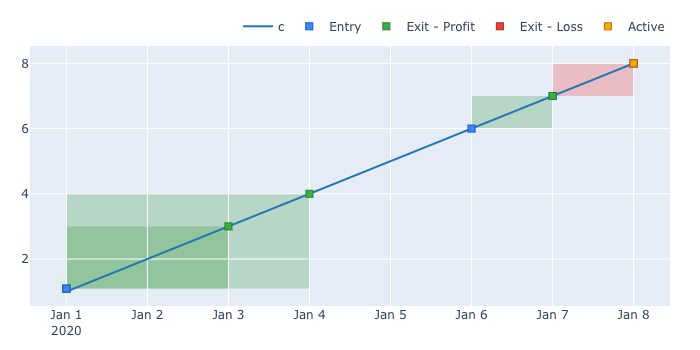

In [56]:
trades['c'].plot().show_png()

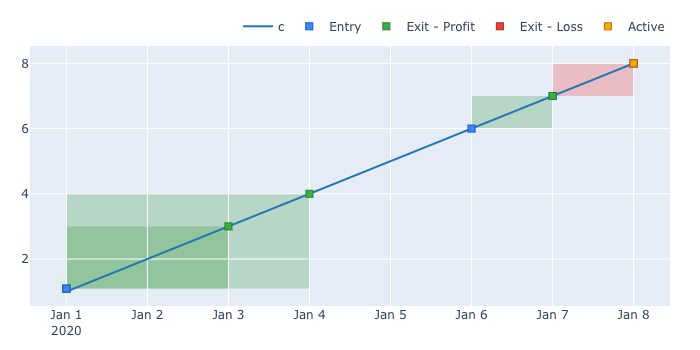

In [57]:
trades.plot(column='c').show_png()

## Positions

In [58]:
positions = vbt.Positions.from_trades(trades)
positions_grouped = vbt.Positions.from_trades(trades_grouped)
print(positions.values.shape)

(10,)


In [59]:
big_positions = vbt.Positions.from_trades(big_trades)
big_positions_grouped = vbt.Positions.from_trades(big_trades_grouped)
print(big_positions.values.shape)

(500000,)


In [60]:
%timeit vbt.Positions.from_trades(big_trades)

29.2 ms ± 6.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [61]:
print(positions.records)
print(positions.close)

print(positions['a'].records)
print(positions['a'].close)

%timeit big_positions.iloc[0]
%timeit big_positions.iloc[:]

%timeit big_positions_grouped.iloc[0]
%timeit big_positions_grouped.iloc[:]

   col  size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0    0   1.1          0     1.090909       0.012         3    3.090909   
1    0   1.0          5     6.000000       0.060         6    7.000000   
2    0   2.0          7     8.000000       0.160         7    8.000000   
3    1   1.1          0     1.090909       0.012         3    3.090909   
4    1   1.0          5     6.000000       0.060         6    7.000000   
5    1   2.0          7     8.000000       0.160         7    8.000000   
6    2   1.1          0     1.090909       0.012         3    3.090909   
7    2   1.0          5     6.000000       0.060         6    7.000000   
8    2   1.0          6     7.000000       0.070         7    8.000000   
9    2   1.0          7     8.000000       0.080         7    8.000000   

   exit_fees    pnl    return  direction  status  position_idx  
0      0.034  2.154  1.795000          0       1             0  
1      0.070  0.870  0.145000          0       1       

In [62]:
print(positions['a'].coverage())
print(positions.coverage())
%timeit big_positions.coverage()

print(positions.coverage(group_by=group_by))
%timeit big_positions.coverage(group_by=big_group_by)

0.5
a    0.500
b    0.500
c    0.625
d    0.000
dtype: float64
19.7 ms ± 850 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
group
first     0.5000
second    0.3125
dtype: float64
16.7 ms ± 357 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Logs

In [63]:
from vectorbt.portfolio.enums import log_dt

records_arr = np.asarray([
    (0, 1, 0, 100.  , 0., 5., 100.  , 1., 0, 2, 5., 0.01, 0., 0., 1e-08, np.inf, 0., False,  True, False,  True, 94.95, 1., 1., 5., 0.05, 0, 0, -1),
    (0, 0, 0,  94.95, 0., 1., 100.  , 1., 0, 2, 1., 0.01, 0., 0., 1e-08, np.inf, 0., False,  True, False,  True, 93.94, 1., 1., 1., 0.01, 0, 0, -1),
    (1, 0, 0,  93.94, 1., 2.,  99.94, 1., 0, 2, 2., 0.01, 0., 0., 1e-08, np.inf, 0., False,  True, False,  True, 91.92, 2., 1., 2., 0.02, 0, 0, -1),
    (1, 1, 0,  91.92, 1., 4.,  99.94, 1., 0, 2, 4., 0.01, 0., 0., 1e-08, np.inf, 0., False,  True, False,  True, 87.88, 2., 1., 4., 0.04, 0, 0, -1),
    (2, 1, 0,  87.88, 2., 3.,  99.88, 1., 0, 2, 3., 0.01, 0., 0., 1e-08, np.inf, 0., False,  True, False,  True, 84.85, 3., 1., 3., 0.03, 0, 0, -1),
    (2, 0, 0,  84.85, 2., 3.,  99.88, 1., 0, 2, 3., 0.01, 0., 0., 1e-08, np.inf, 0., False,  True, False,  True, 81.82, 3., 1., 3., 0.03, 0, 0, -1),
    (3, 1, 0,  81.82, 3., 2.,  99.82, 1., 0, 2, 2., 0.01, 0., 0., 1e-08, np.inf, 0., False,  True, False,  True, 79.8 , 4., 1., 2., 0.02, 0, 0, -1),
    (3, 0, 0,  79.8 , 3., 4.,  99.82, 1., 0, 2, 4., 0.01, 0., 0., 1e-08, np.inf, 0., False,  True, False,  True, 75.76, 4., 1., 4., 0.04, 0, 0, -1),
    (4, 1, 0,  75.76, 4., 1.,  99.76, 1., 0, 2, 1., 0.01, 0., 0., 1e-08, np.inf, 0., False,  True, False,  True, 74.75, 5., 1., 1., 0.01, 0, 0, -1),
    (4, 0, 0,  74.75, 4., 5.,  99.76, 1., 0, 2, 5., 0.01, 0., 0., 1e-08, np.inf, 0., False,  True, False,  True, 69.7 , 5., 1., 5., 0.05, 0, 0, -1)
], dtype=log_dt)
print(records_arr.shape)

wrapper = vbt.ArrayWrapper([
    datetime(2020, 1, 1),
    datetime(2020, 1, 2),
    datetime(2020, 1, 3),
    datetime(2020, 1, 4),
    datetime(2020, 1, 5),
    datetime(2020, 1, 6)
], ['a', 'b'], 2)
logs = vbt.Logs(wrapper, records_arr)
logs_grouped = vbt.Logs(wrapper.regroup(True), records_arr)

(10,)


In [64]:
print(logs['a'].records)

   idx  col  group  cash_now  shares_now  val_price_now  value_now  size  \
0    0    0      0     94.95         0.0            1.0     100.00   1.0   
1    1    0      0     93.94         1.0            2.0      99.94   1.0   
2    2    0      0     84.85         2.0            3.0      99.88   1.0   
3    3    0      0     79.80         3.0            4.0      99.82   1.0   
4    4    0      0     74.75         4.0            5.0      99.76   1.0   

   size_type  direction  ...  raise_reject   log  new_cash  new_shares  \
0          0          2  ...         False  True     93.94         1.0   
1          0          2  ...         False  True     91.92         2.0   
2          0          2  ...         False  True     81.82         3.0   
3          0          2  ...         False  True     75.76         4.0   
4          0          2  ...         False  True     69.70         5.0   

   res_size  res_price  res_fees  res_side  res_status  res_status_info  
0       1.0        1.0  

In [65]:
print(logs.records_readable)

     Context                                                Order            \
        Date Column Group    Cash Shares Val. Price   Value  Size Size Type   
0 2020-01-01      b     0  100.00    0.0        5.0  100.00   1.0    Shares   
1 2020-01-01      a     0   94.95    0.0        1.0  100.00   1.0    Shares   
2 2020-01-02      a     0   93.94    1.0        2.0   99.94   1.0    Shares   
3 2020-01-02      b     0   91.92    1.0        4.0   99.94   1.0    Shares   
4 2020-01-03      b     0   87.88    2.0        3.0   99.88   1.0    Shares   
5 2020-01-03      a     0   84.85    2.0        3.0   99.88   1.0    Shares   
6 2020-01-04      b     0   81.82    3.0        2.0   99.82   1.0    Shares   
7 2020-01-04      a     0   79.80    3.0        4.0   99.82   1.0    Shares   
8 2020-01-05      b     0   75.76    4.0        1.0   99.76   1.0    Shares   
9 2020-01-05      a     0   74.75    4.0        5.0   99.76   1.0    Shares   

             ...                          Result   

In [66]:
print(logs['a'].count())
print(logs.count())

5
a    5
b    5
dtype: int64
